# DeltaIoTv2

In [2]:
from code_base.analysis import *
from code_base.model import *
from code_base.simulation import *
from code_base.solution import *
from code_base.visualization import *

In [3]:
folder_path = 'data/log'

# DLASeR+

In [4]:
class Enum(tuple): __getattr__ = tuple.index
Operator = Enum(['Min', 'Max'])

def operator_to_thresh_str(operator):
    if operator == Operator.Min:
        return '<'
    elif operarie == Operator.Max:
        return '>'
    raise ValueError('Given operator is not valid: ' + operator)

def operator_to_opt_str(operator):
    if operator == Operator.Min:
        return 'Minimize'
    elif operarie == Operator.Max:
        return 'Maximize'
    raise ValueError('Given operator is not valid: ' + operator)

def operator_to_math(operator):
    if operator == Operator.Min:
        return lambda x, y: x < y
    elif operarie == Operator.Max:
        return lambda x, y: x > y
    raise ValueError('Given operator is not valid: ' + operator)

from dataclasses import dataclass

@dataclass
class ThresholdGoal:
    quality: str
    operator: Operator
    value: float

@dataclass
class SetpointGoal:
    quality: str
    value: float
    epsilon: float

@dataclass
class OptimizationGoal:
    quality: str
    operator: Operator

class DLFramework:

    def __init__(self, qualities):
        self.qualities = qualities
        self.threshold_goals = {}
        self.setpoint_goals = {}
        self.optimization_goals = {}


    def _get_threshold_name(self, quality, threshold_value):
        name = quality+'_thresh'+str(threshold_value)
        return name

    def _get_setpoint_name(self, quality, setpoint_value):
        name = quality+'_setpoint'+str(setpoint_value)
        return name

    def _get_optimization_name(self, quality):
        name = quality+'_opt'
        return name


    def add_theshold_goal(self, quality, operator, threshold_value):
        assert quality in self.qualities # Must be a known quality
        threshold_goal = ThresholdGoal(quality, operator, threshold_value)
        name = self._get_threshold_name(quality, threshold_value)
        self.threshold_goals[name] = threshold_goal

    def add_setpoint_goal(self, quality, setpoint_value, epsilon):
        assert quality in self.qualities # Must be a known quality
        setpoint_goal = SetpointGoal(quality, setpoint_value, epsilon)
        name = self._get_setpoint_name(quality, setpoint_value)
        self.setpoint_goals[name] = setpoint_goal

    def add_optimizataion_goal(self, quality, operator):
        assert quality in self.qualities # Must be a known quality
        assert len(self.optimization_goals) == 0 # We do not support multi-optimization goals
        optimization_goal = OptimizationGoal(quality, operator)
        name = self._get_optimization_name(quality)
        self.optimization_goals[name] = optimization_goal


    def print_goals(self):
        if len(self.threshold_goals) > 0:
            print('-'*10+' THRESHOLD GOALS '+10*'-')
            for threshold_goal in self.threshold_goals.values():
                print(threshold_goal.quality, operator_to_thresh_str(threshold_goal.operator), threshold_goal.value)
        if len(self.setpoint_goals) > 0:
            print('-'*10+' SET-POINT GOALS '+10*'-')
            for setpoint_goal in self.setpoint_goals.values():
                print(setpoint_goal.quality, '==', setpoint_goal.value)
        if len(self.optimization_goals) > 0:
            print('-'*9+' OPTIMIZATION GOALS '+9*'-')
            for optimization_goal in self.optimization_goals.values():
                print(operator_to_opt_str(optimization_goal.operator), optimization_goal.quality)

### Integrate general model framework in DLASeR

https://keras.io/getting-started/functional-api-guide/

In [9]:
from keras import backend as K

## The metrics

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## The core layers

from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2, l1

# The core layers shared by all the specific tasks
def build_core_model(layers): 
    inp = Input(shape=(207,), dtype='float32', name='main_input')
    x = Dense(layers[0], activation='relu', kernel_regularizer=l1(0.0005))(inp)
    #x = Dropout(0.1)(x)
    for layer in layers[1:-1]:
        x = BatchNormalization()(x)
        x = Dense(layer, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    outp = Dense(layers[-1], activation='relu', kernel_regularizer=l2(0.0005), name='embedding')(x)

    model = Model(inputs=[inp], outputs=[outp])
    
    return model


## The adpatation goal heads head

CLASSIFICATION_LOSS = 'binary_crossentropy'
CLASSIFICATION_METRICS = ['acc']
CLASSIFICATION_METRICS_EXTENSIVE = ['acc', f1_m, precision_m, recall_m]
REGRESSION_LOSS = 'mse'
REGRESSION_METRICS = []

def layer_names_to_loss(layer_names):
    # layer_names are the output layers
    loss = {}
    for layer_name in layer_names:
        if '_class_' in layer_name: # In case of classification
            loss[layer_name] = CLASSIFICATION_LOSS
        elif '_regr_' in layer_name: # In case of regression
            loss[layer_name] = REGRESSION_LOSS
        else:
            raise ValueError('Illegal layer name given: ' + layer_name)
    return loss

def layer_names_to_metrics(layer_names, extensive):
    # layer_names are the output layers
    metrics = {}
    for layer_name in layer_names:
        if '_class_' in layer_name: # In case of classification
            if extensive:
                metrics[layer_name] = CLASSIFICATION_METRICS_EXTENSIVE
            else:
                metrics[layer_name] = CLASSIFICATION_METRICS
        elif '_regr_' in layer_name: # In case of regression
            metrics[layer_name] = REGRESSION_METRICS
        else:
            raise ValueError('Illegal layer name given: ' + layer_name)
    return metrics

def equal_regr_and_class_weights(layer_names):
    weights = {}
    regr_count = sum([1 if '_regr_' in name else 0 for name in layer_names])
    class_count = len(layer_names) - regr_count
    if regr_count != 0 and class_count != 0:
        for name in layer_names:
            if '_regr_' in name:
                weights[name] = 1/(regr_count)
            elif '_class_' in name:
                weights[name] = 1/(class_count)
            else:
                raise ValueError('Illegal layer name given: ' + name)
        return weights
    else: # Only of 1 type
        return [1]*(len(layer_names))


# Add classification head to core model (or a model with already several heads)
def add_classification_head(core_model, quality, layers):
    inp = core_model.get_layer('main_input').output
    embedding_layer = core_model.get_layer('embedding').output

    x = Dense(layers[0], activation='relu', kernel_regularizer=l1(0.0005))(embedding_layer)
    #x = Dropout(0.1)(x)
    for layer in layers[1:]:
        x = BatchNormalization()(x)
        x = Dense(layer, activation='relu', kernel_regularizer=l2(0.0005))(x)
    outp = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0005), name='output_class_'+quality)(x)

    outputs = []
    if core_model.layers[-1].name.startswith('output_'): # In the case that the model contains already some classification heads
        idx = -1
        while core_model.layers[idx].name.startswith('output_'):
            outputs.append(core_model.layers[idx].output)
            idx -= 1

    outputs.append(outp)

    model = Model(inputs=[inp], outputs=outputs)

    return model



# Add regression head to core model (or a model with already several heads)
def add_regression_head(core_model, quality, layers):
    inp = core_model.get_layer('main_input').output
    embedding_layer = core_model.get_layer('embedding').output

    x = Dense(layers[0], activation='relu', kernel_regularizer=l1(0.0005))(embedding_layer)
    #x = Dropout(0.1)(x)
    for layer in layers[1:]:
        x = BatchNormalization()(x)
        x = Dense(layer, activation='relu', kernel_regularizer=l2(0.0005))(x)
    outp = Dense(1, kernel_regularizer=l2(0.0005), name='output_regr_'+quality)(x)

    outputs = []
    if core_model.layers[-1].name.startswith('output_'): # In the case that the model contains already some classification heads
        idx = -1
        while core_model.layers[idx].name.startswith('output_'):
            outputs.append(core_model.layers[idx].output)
            idx -= 1

    outputs.append(outp)

    model = Model(inputs=[inp], outputs=outputs)

    return model



from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class DLASeR(DLFramework):

    def __init__(self, qualities, core_layers):
        super().__init__(qualities)
        self.model = build_core_model(core_layers)
        self.callback = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.3, min_lr=0.0001)]

    def add_theshold_goal(self, quality, operator, threshold_value, class_layers):
        super().add_theshold_goal(quality, operator, threshold_value)
        name = self._get_threshold_name(quality, threshold_value)
        self.model = add_classification_head(self.model, name, class_layers)

    def add_setpoint_goal(self, quality, setpoint_value, epsilon, class_layers):
        super().add_setpoint_goal(quality, setpoint_value, epsilon)
        name = self._get_setpoint_name(quality, setpoint_value)
        self.model = add_classification_head(self.model, name, class_layers)

    def add_optimizataion_goal(self, quality, operator, regr_layers):
        super().add_optimizataion_goal(quality, operator)
        name = self._get_optimization_name(quality)
        self.model = add_regression_head(self.model, name, regr_layers)

    def _y_dict_to_output(self, y_dict):
        for quality in y_dict.keys():
            assert(quality in self.qualities) # Make sure the quality is known 
        outputs = {}
        # Threshold goals
        for name, threshold_goal in self.threshold_goals.items():
            quality = threshold_goal.quality
            quality_vals = y_dict[quality]
            operator_math = operator_to_math(threshold_goal.operator)
            y = np.array([operator_math(val, threshold_goal.value) for val in quality_vals]).astype(np.int)
            outputs['output_class_'+name] = y
        # Set-point goals
        for name, setpoint_goal in self.setpoint_goals.items():
            quality = setpoint_goal.quality
            quality_vals = y_dict[quality]
            setpoint = setpoint_goal.value
            epsilon = setpoint_goal.epsilon
            y = np.array([setpoint - epsilon < val < setpoint + epsilon for val in quality_vals]).astype(np.int)
            outputs['output_class_'+name] = y
        # Optimization goals
        for name, optimization_goal in self.optimization_goals.items():
            quality = optimization_goal.quality
            y = y_dict[quality]
            outputs['output_regr_'+name] = y
        return outputs    
            

    # The online train method
    def train(self, x, y_dict, batch_size, epochs, verbose=True):
        return self.model.fit({'main_input': x},
                              self._y_dict_to_output(y_dict),
                              batch_size=batch_size, epochs=epochs,
                              callbacks=self.callback, 
                              validation_split=0.1,
                              verbose=verbose)

    # The fit method
    def fit(self, x_train, x_val, y_dict_train, y_dict_val, batch_size, epochs, verbose=True):
        return self.model.fit({'main_input' : x_train}, self._y_dict_to_output(y_dict_train),
                              batch_size=batch_size, epochs=epochs,
                              validation_data=[{'main_input' : x_val}, self._y_dict_to_output(y_dict_val)],
                              callbacks=self.callback,
                              verbose=verbose)

    # The offline fit method (used for the grid search)
    # The callback is a specific talos callback
    def fit_gridsearch(self, x_train, x_val, y_dict_train, y_dict_val, batch_size, epochs, callback, verbose=True):
        return self.model.fit({'main_input' : x_train}, self._y_dict_to_output(y_dict_train),
                              batch_size=batch_size, epochs=epochs,
                              validation_data=[{'main_input' : x_val}, self._y_dict_to_output(y_dict_val)],
                              callbacks=[callback],
                              verbose=verbose)
    
    # Necessary to compile dlaser before training or fitting
    def compile(self, optimizer, lr, extensive_metrics=False):
        outputs_names = []
        if self.model.layers[-1].name.startswith('output_'): # In the case that the model contains already some classification / regression heads
            idx = -1
            while self.model.layers[idx].name.startswith('output_'):
                outputs_names.append(self.model.layers[idx].name)
                idx -= 1

        self.model.compile(optimizer=optimizer(lr=lr),
                           loss=layer_names_to_loss(outputs_names),
                           metrics=layer_names_to_metrics(outputs_names, extensive=extensive_metrics),
                           loss_weights=equal_regr_and_class_weights(outputs_names))

    def predict(self, x):
        pred = self.model.predict(x, use_multiprocessing=True)
        names = []
        idx = -1
        while self.model.layers[idx].name.startswith('output_'):
            names.append(self.model.layers[idx].name)
            idx -= 1
        return pred, names[::-1] # Appearantly keras predicts in the reverse order

    def save_model(self, filename):
        self.model.save(filename+'.h5')

    def load_model(self, filename):
        self.model.load_weights(filename+'.h5')

    def get_model(self):
        return self.model

    def print_model(self):
        self.model.summary()

# Offline evaluation - v2

## General offline simulation settings

In [5]:
nb_cycles = 300
version ='v2'
LEARNING_CYCLES = 1
cycle=250
folder_path = 'data/log'

## Grid search

In [6]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler

class IDScaler:
    def fit(self, x):
        pass
    def partial_fit(self, x):
        pass
    def fit_transform(self, x):
        return x
    def transform(self, x):
        return x

# Fetch 30 cycles of data
nb_cycles = 30
dfs = []
nb_opts = len(construct_cycle_df(folder_path, 1))
for c in range(10,nb_cycles+10):
    df = construct_cycle_df(folder_path, c)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

# Get x features
def get_features(df):
    return np.array([np.hstack(row) for row in  df.drop(['energyconsumption', 'packetloss', 'latency'], axis=1).values])
X = get_features(df)

# Get y features
def get_qualities(df, quality):
    return np.array([q for q in df[quality].values])
y_pl = get_qualities(df, 'packetloss')
y_la = get_qualities(df, 'latency')
y_ec = get_qualities(df, 'energyconsumption')

# Use this data to train and split
print(X.shape)
print(y_pl.shape, y_la.shape, y_ec.shape)

(122880, 207)
(122880,) (122880,) (122880,)


In [ ]:
import seaborn as sns
def plot_cols(cols, df):
    nb_plots = len(cols) / 2
    nb_rows = nb_plots//3 + 1
    plt.figure(figsize=(27,6*nb_rows))
    idx = 1
    for col in cols:
        if not 'val_' in col:
            plt.subplot(nb_rows,3,idx)
            sns.kdeplot(df['val_' + col])
            sns.kdeplot(df[col])
            idx += 1
    plt.tight_layout()

### Setup 1

**T1**: PL < 10%  
**T2**: LA < 5%  
**O1**: minimize EC

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2, l1
from talos.model.early_stopper import early_stopper

# y_train and y_val are dictionaries of {quality: data}
def build_dlaser_pipeline_setup1(x_train, y_train, x_val, y_val, params):
    callback=early_stopper(params['epochs'], monitor='val_loss', mode='moderate')

    dlaser = DLASeR(['packetloss', 'latency', 'energyconsumption'], params['core_params'])
    dlaser.add_theshold_goal('packetloss', Operator.Min, 10, params['class_params'])
    dlaser.add_theshold_goal('latency', Operator.Min, 5, params['class_params'])
    dlaser.add_optimizataion_goal('energyconsumption', Operator.Min, params['regr_params'])

    scaler = params['scaler']
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    dlaser.compile(params['optimizer'], params['lr'], extensive_metrics=True)

    out = dlaser.fit_gridsearch(x_train, x_val,
                                y_train, y_val,
                                batch_size=params['batch_size'], epochs=params['epochs'],
                                callback=callback,
                                verbose=False)
    model = dlaser.get_model()

    return out, model

In [ ]:
# Grid options
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
p = {
    'core_params' : [[100,50,25],[200,100,50,25],[180,240,120,80,25]],
    'class_params' : [[20,10,5],[30,10,4],[40,20,10,5]],
    'regr_params' : [[20,10,5],[30,40,15,5],[40,20,10,5]],
    'scaler' : [IDScaler(), MaxAbsScaler(), MinMaxScaler(), StandardScaler()],
    'epochs' : [30],
    'optimizer' : [RMSprop, Adam, Nadam],
    'lr' : [5e-3, 2e-3, 5e-4, 2e-4],
    'batch_size' : [512, 1028, 2056]
}

In [ ]:
import talos
t = talos.Scan(X[:25*nb_opts], {'packetloss': y_pl[:25*nb_opts], 'latency': y_la[:25*nb_opts], 'energyconsumption' : y_ec[:25*nb_opts]}, # First 25 cycles -> train cycles
               x_val=X[25*nb_opts:], y_val={'packetloss': y_pl[25*nb_opts:], 'latency': y_la[25*nb_opts:], 'energyconsumption' : y_ec[25*nb_opts:]}, # Last 5 cycles -> test cycles
               model=build_dlaser_pipeline_setup1,
               params=p, experiment_name='setup1_deltaIoTv2')


100%|██████████| 1296/1296 [12:13:49<00:00, 33.97s/it]


In [ ]:
t.data.to_csv('gridsearch_setup1_v2.csv')

#### Evaluation

In [ ]:
df = pd.read_csv('gridsearch_setup1_v2.csv')
df.head()

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
0,0,9,289.938420,1.548530,0.175110,288.818085,0.736532,0.843349,0.736532,1.000000,0.932658,0.428997,0.515227,0.477007,9.543675,0.173218,0.134100,9.123682,0.922646,0.948366,0.936934,0.960893,0.942402,0.803562,0.834652,0.782889,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
1,1,11,6.076203,0.159922,0.129751,5.599316,0.928141,0.946323,0.964235,0.933044,0.956095,0.402220,0.635649,0.324822,1.605085,0.140431,0.130288,1.124008,0.940781,0.960169,0.955446,0.965477,0.945391,0.814015,0.842502,0.794566,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
2,2,9,9.233301,0.183643,0.155446,8.788113,0.921346,0.945809,0.908996,0.988258,0.931030,0.186979,0.490265,0.126471,4.421417,0.144287,0.130268,4.005510,0.937266,0.957926,0.949933,0.966450,0.944844,0.812802,0.836762,0.796886,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
3,3,4,792.888513,0.601444,0.167194,792.309753,0.765218,0.771782,0.908294,0.757048,0.933146,0.174964,0.514269,0.111670,10.161901,0.168618,0.143111,9.814250,0.925596,0.950188,0.940796,0.960550,0.939121,0.791644,0.825637,0.769679,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
4,4,4,120.091310,0.328497,1.145630,118.879128,0.858439,0.885885,0.981386,0.815596,0.500326,0.184607,0.111864,0.854167,5.578993,0.225016,0.195170,4.902530,0.904951,0.936451,0.925850,0.948060,0.919297,0.709811,0.785159,0.662796,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

loss_cols = []
acc_cols = []
prec_cols = []
rec_cols = []
f1_cols = []
for col in df.columns:
    if '_loss' in col and col != 'val_loss':
        loss_cols.append(col)
    elif '_acc' in col:
        acc_cols.append(col)
    elif '_precision' in col:
        prec_cols.append(col)
    elif '_recall' in col:
        rec_cols.append(col)
    elif '_f1' in col:
        f1_cols.append(col)
    
print(loss_cols)
print(acc_cols)
print(prec_cols)
print(rec_cols)
print(f1_cols)

['val_output_class_latency_thresh5_loss', 'val_output_class_packetloss_thresh10_loss', 'val_output_regr_energyconsumption_opt_loss', 'output_class_latency_thresh5_loss', 'output_class_packetloss_thresh10_loss', 'output_regr_energyconsumption_opt_loss']
['val_output_class_latency_thresh5_acc', 'val_output_class_packetloss_thresh10_acc', 'output_class_latency_thresh5_acc', 'output_class_packetloss_thresh10_acc']
['val_output_class_latency_thresh5_precision_m', 'val_output_class_packetloss_thresh10_precision_m', 'output_class_latency_thresh5_precision_m', 'output_class_packetloss_thresh10_precision_m']
['val_output_class_latency_thresh5_recall_m', 'val_output_class_packetloss_thresh10_recall_m', 'output_class_latency_thresh5_recall_m', 'output_class_packetloss_thresh10_recall_m']
['val_output_class_latency_thresh5_f1_m', 'val_output_class_packetloss_thresh10_f1_m', 'output_class_latency_thresh5_f1_m', 'output_class_packetloss_thresh10_f1_m']


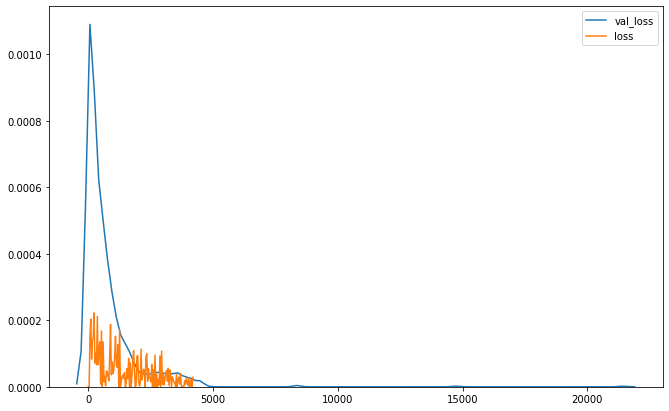

In [ ]:
plt.figure(figsize=(11,7))
sns.kdeplot(df['val_loss'])
sns.kdeplot(df['loss'])

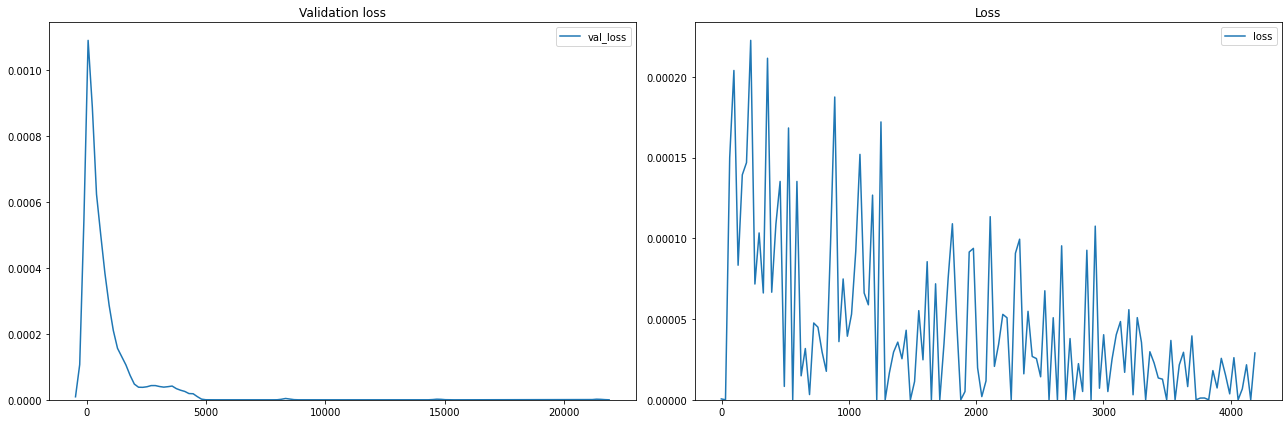

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Validation loss')
sns.kdeplot(df['val_loss'])
plt.subplot(1,2,2)
plt.title('Loss')
sns.kdeplot(df['loss'])
plt.tight_layout()

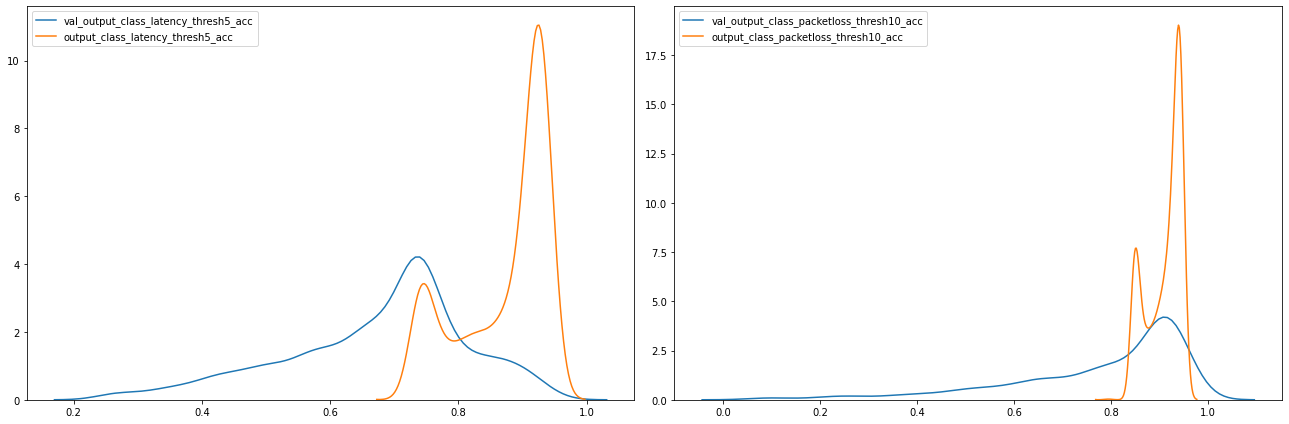

In [ ]:
plot_cols(acc_cols, df)

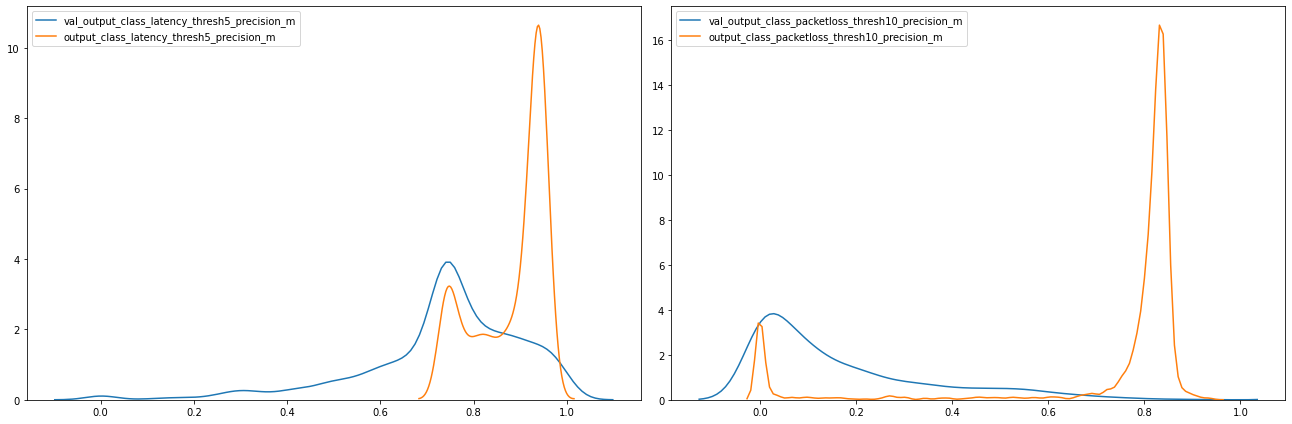

In [ ]:
plot_cols(prec_cols, df)

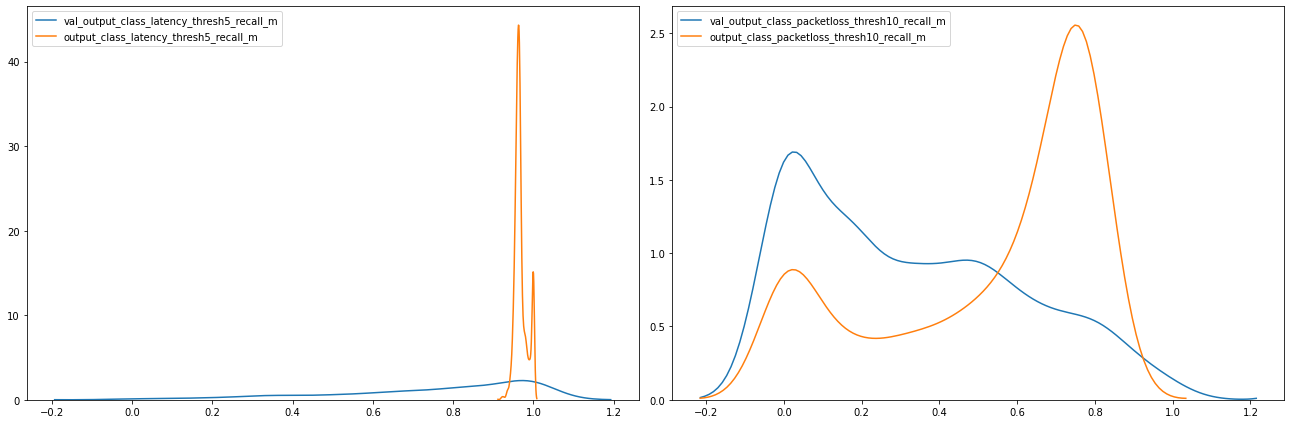

In [ ]:
plot_cols(rec_cols, df)

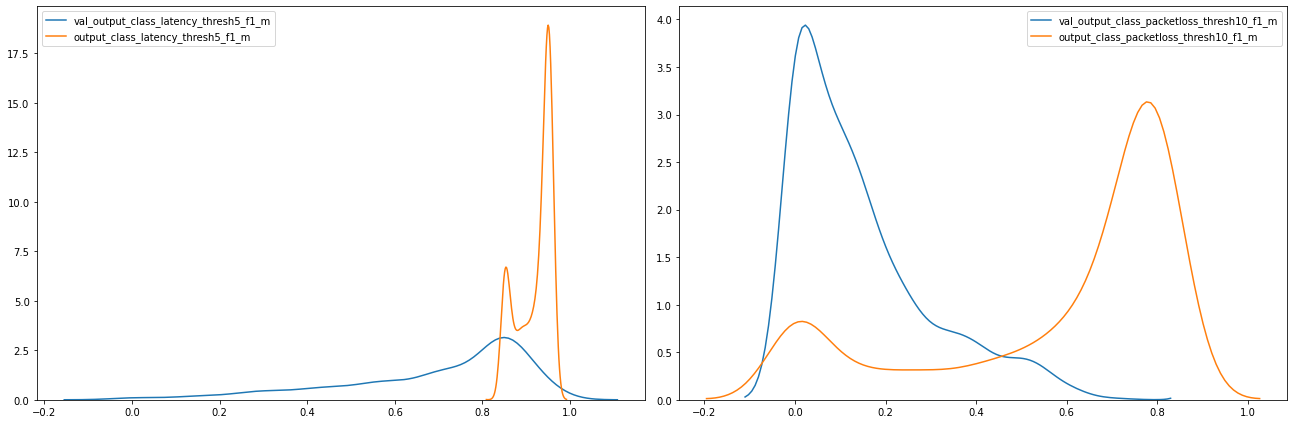

In [ ]:
plot_cols(f1_cols, df)

In [ ]:
df[df['val_loss'] == min(df['val_loss'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
302,302,30,0.919072,0.157853,0.105251,0.319174,0.93571,0.951531,0.978103,0.92766,0.953084,0.594418,0.548953,0.686914,1.030125,0.130185,0.122654,0.421553,0.941533,0.960707,0.954717,0.96708,0.947578,0.823033,0.844526,0.807478,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."


In [ ]:
df.sort_values('val_loss')[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
302,302,30,0.919072,0.157853,0.105251,0.319174,0.935710,0.951531,0.978103,0.927660,0.953084,0.594418,0.548953,0.686914,1.030125,0.130185,0.122654,0.421553,0.941533,0.960707,0.954717,0.967080,0.947578,0.823033,0.844526,0.807478,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
86,86,22,0.998679,0.203761,0.102356,0.335264,0.918213,0.943343,0.917224,0.973965,0.953044,0.567477,0.535676,0.671141,1.018237,0.132055,0.126423,0.353650,0.941943,0.960941,0.956427,0.965796,0.945801,0.815896,0.841370,0.796898,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
148,148,14,1.139009,0.268553,0.127409,0.466744,0.900920,0.934207,0.881193,0.996748,0.953084,0.417645,0.687854,0.339361,1.801888,0.161743,0.156695,1.119294,0.929619,0.952915,0.942901,0.963567,0.936514,0.779140,0.822541,0.750802,512,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
16,16,20,1.160183,0.183166,0.149106,0.617404,0.918416,0.937662,0.978712,0.902408,0.937134,0.493018,0.472722,0.636670,0.876702,0.142191,0.125956,0.355032,0.935322,0.956762,0.946058,0.968256,0.945449,0.815315,0.836976,0.800561,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
164,164,23,1.259105,0.309826,0.154783,0.390756,0.889160,0.926989,0.868605,0.998083,0.930461,0.514333,0.460293,0.684005,2.385237,0.140480,0.136000,1.589092,0.939551,0.959397,0.953394,0.965747,0.942529,0.805403,0.827538,0.789819,512,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
166,166,17,1.318968,0.223579,0.232526,0.416719,0.897542,0.921396,0.961870,0.892765,0.891439,0.421891,0.308691,0.773357,2.875225,0.171222,0.137675,2.038203,0.924648,0.949592,0.939636,0.960222,0.941748,0.800060,0.835643,0.774711,512,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
230,230,17,1.351445,0.357301,0.527779,0.517710,0.895793,0.928318,0.906566,0.961192,0.732341,0.338783,0.256228,0.765018,0.871516,0.142945,0.122045,0.342896,0.934785,0.956357,0.946791,0.966512,0.947773,0.823799,0.843195,0.809975,512,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
386,386,9,1.452504,0.356782,0.111267,0.394639,0.863118,0.890348,0.968075,0.839310,0.953939,0.440599,0.587107,0.401751,3.326432,0.172627,0.146621,2.341449,0.923721,0.948870,0.940476,0.957807,0.937764,0.784583,0.824620,0.753869,512,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, 

#### Check other metrics

Accuracy

In [ ]:
print(acc_cols)

['val_output_class_latency_thresh5_acc', 'val_output_class_packetloss_thresh10_acc', 'output_class_latency_thresh5_acc', 'output_class_packetloss_thresh10_acc']


In [ ]:
df[df['val_output_class_latency_thresh5_acc'] == min(df['val_output_class_latency_thresh5_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
15,15,13,774.685337,6.027153,1.202921,770.683899,0.263468,0.0,0.0,0.0,0.912231,0.000000,0.000000,0.000000,9.533449,0.157596,0.131693,8.993778,0.928984,0.952490,0.942648,0.963139,0.944004,0.807533,0.843111,0.780861,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
21,21,10,505.509981,9.428432,1.304573,499.875519,0.263468,0.0,0.0,0.0,0.581340,0.226929,0.141990,0.852544,6.050846,0.160482,0.133836,5.630575,0.927705,0.951682,0.940602,0.963414,0.942178,0.801870,0.836927,0.776172,512,"[30, 10, 4]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
84,84,8,6.999455,6.918459,2.246359,1.545536,0.263468,0.0,0.0,0.0,0.655436,0.175041,0.270724,0.402597,1.939472,0.161593,0.139398,0.894166,0.928398,0.952094,0.942486,0.962298,0.941328,0.799951,0.826654,0.779974,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
504,504,8,35.715627,8.463853,1.123471,30.518415,0.263468,0.0,0.0,0.0,0.592733,0.323405,0.222717,0.954076,4.825932,0.330641,0.156070,4.244992,0.853262,0.906685,0.854204,0.967406,0.933975,0.767446,0.821956,0.736079,1028,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
577,577,8,54.010631,1.278044,0.413373,52.720066,0.263468,0.0,0.0,0.0,0.909139,0.527200,0.414041,0.845277,5.948961,0.318227,0.171593,5.196362,0.856631,0.906618,0.874276,0.942890,0.930557,0.753677,0.820247,0.718723,1028,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
651,651,5,403.559583,6.732678,0.388386,398.967926,0.263468,0.0,0.0,0.0,0.823161,0.407544,0.324247,0.716220,7.830157,0.195665,0.152637,7.271897,0.914307,0.942728,0.933746,0.952297,0.934834,0.778607,0.805059,0.759680,1028,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
805,805,5,75.402607,1.418826,0.344543,74.502533,0.263468,0.0,0.0,0.0,0.853963,0.035504,0.030030,0.068021,7.317500,0.333670,0.208770,6.137177,0.851406,0.906458,0.848175,0.973722,0.918838,0.680095,0.846031,0.572374,1028,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
873,873,9,221.364186,3.332678,0.327232,218.147415,0.263468,0.0,0.0,0.0,0.888346,0.235635,0.250788,0.497432,3.240150,0.147872,0.123078,2.461168,0.933652,0.955627,0.945779,0.965847,0.947490,0.821190,0.849578,0.796588,2056,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
936,936,9,443.340207,3.934557,0.168581,439.169769,0.263468,0.0,0.0,0.0,0.933675,0.543807,0.459167,0.695507,8.138717,0.237896,0.159387,7.505434,0.899297,0.931687,0.925146,0.941278,0.934004,0.769026,0.827116,0.737067,2056,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 

In [ ]:
df[df['val_output_class_packetloss_thresh10_acc'] == min(df['val_output_class_packetloss_thresh10_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
304,304,7,5.258750,1.156213,4.561643,1.697172,0.472290,0.345483,0.580861,0.285159,0.087769,0.145391,0.087769,0.854167,5.255387,0.162872,0.170622,4.365459,0.927676,0.951664,0.940578,0.963486,0.924785,0.718535,0.830392,0.637782,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
591,591,5,786.650169,0.603284,1.269129,782.926941,0.736532,0.846332,0.737219,1.000000,0.087769,0.151549,0.088771,0.958333,6.445816,0.569216,0.352772,4.955445,0.740098,0.850551,0.740099,1.000000,0.855352,0.121278,0.726069,0.071410,1028,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
801,801,7,851.083551,0.770269,2.201952,855.072083,0.736491,0.846309,0.737213,0.999953,0.087769,0.151549,0.088771,0.958333,4.909329,0.349312,0.241699,3.632550,0.841211,0.901477,0.833447,0.981922,0.899482,0.574406,0.812990,0.454546,1028,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]",MaxAbsScaler(copy=True)


In [ ]:
df.sort_values('val_output_class_latency_thresh5_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
368,368,16,3.047595,0.147395,0.150413,2.402024,0.937948,0.953260,0.976739,0.931909,0.937785,0.344442,0.484227,0.334974,1.344650,0.146734,0.133383,0.677198,0.938828,0.958959,0.951565,0.966780,0.944482,0.811461,0.837071,0.793784,512,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
302,302,30,0.919072,0.157853,0.105251,0.319174,0.935710,0.951531,0.978103,0.927660,0.953084,0.594418,0.548953,0.686914,1.030125,0.130185,0.122654,0.421553,0.941533,0.960707,0.954717,0.967080,0.947578,0.823033,0.844526,0.807478,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
19,19,6,690.217230,0.159821,0.122649,689.808105,0.933024,0.952801,0.928775,0.980502,0.951619,0.513175,0.580939,0.533858,8.539749,0.146339,0.128708,8.130392,0.934658,0.956222,0.947925,0.965147,0.944424,0.809658,0.842991,0.785714,512,"[30, 10, 4]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
77,77,7,2.481818,0.168833,0.105125,1.895202,0.932821,0.952932,0.931329,0.977882,0.955770,0.496263,0.559412,0.491471,6.300709,0.160019,0.142955,5.684540,0.932227,0.954445,0.948901,0.960676,0.941201,0.800083,0.828345,0.782993,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
235,235,9,12.050828,0.204695,0.100823,11.623672,0.930786,0.947166,0.985029,0.913947,0.955037,0.436579,0.660202,0.356809,7.148424,0.145792,0.126499,6.736295,0.934922,0.956505,0.945705,0.968030,0.945215,0.813372,0.840891,0.793824,512,"[40, 20, 10, 5]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
439,439,10,29.661733,0.192452,0.140034,29.587301,0.929972,0.952611,0.931919,0.976662,0.935628,0.577651,0.705451,0.613963,5.077179,0.143839,0.126651,4.620355,0.936650,0.957491,0.950260,0.965093,0.946250,0.818252,0.839626,0.800982,1028,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
289,289,23,2.924868,0.161846,0.162583,2.460765,0.929443,0.949301,0.942687,0.960381,0.933553,0.436382,0.597298,0.471377,1.366914,0.134660,0.124235,0.929251,0.940928,0.960294,0.954757,0.966319,0.946406,0.816883,0.847176,0.794425,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1178,1178,30,3.570513,0.171450,0.330882,2.983617,0.929199,0.951549,0.961359,0.944072,0.857381,0.508063,0.360018,0.980346,2.531674,0.130183,0.125005,2.058812,0.943213,0.961895,0.954449,0.969564,0.948203,0.824741,0.847157,0.805693,2056,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_

In [ ]:
df.sort_values('val_output_class_packetloss_thresh10_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
5,5,5,47.376169,0.402968,0.085346,46.870609,0.836507,0.862387,0.990548,0.776665,0.964355,0.533096,0.613708,0.500394,8.784023,0.141179,0.132253,8.371627,0.939141,0.959127,0.953062,0.965668,0.943408,0.807624,0.832857,0.791914,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
434,434,13,77.784333,0.515751,0.097014,77.014824,0.803874,0.847373,0.965281,0.773410,0.963298,0.632014,0.613546,0.677302,3.411201,0.141704,0.127869,3.089656,0.939238,0.959194,0.952465,0.966259,0.945859,0.816101,0.841201,0.798383,1028,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
379,379,11,15.462258,0.262353,0.094468,14.714068,0.897746,0.918901,0.959078,0.893278,0.963175,0.490361,0.660144,0.419627,2.430560,0.158203,0.147717,1.706448,0.932793,0.954864,0.948509,0.961738,0.937705,0.785052,0.822990,0.758722,512,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
440,440,4,312.078851,0.277235,0.103903,311.266235,0.891113,0.919853,0.964918,0.884422,0.959554,0.540684,0.674893,0.483254,7.797578,0.195654,0.145081,7.287717,0.916201,0.943944,0.933231,0.955423,0.938818,0.791810,0.822047,0.770022,1028,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
293,293,13,5.370598,0.687883,0.099684,4.716247,0.689168,0.704695,0.970107,0.601226,0.958171,0.552410,0.570733,0.617914,1.985996,0.136973,0.129080,1.581827,0.940176,0.959753,0.954657,0.965226,0.944082,0.809923,0.839714,0.788249,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
944,944,12,35.493657,0.171863,0.100204,34.944054,0.922282,0.948841,0.919007,0.982634,0.957560,0.719364,0.737637,0.776103,3.991395,0.153162,0.132587,3.392808,0.934717,0.956183,0.950505,0.962100,0.945332,0.812482,0.848819,0.783635,2056,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
1085,1085,10,18.347621,0.167404,0.104480,17.938330,0.928752,0.950242,0.978013,0.924854,0.957520,0.540720,0.869909,0.424117,4.612985,0.136816,0.131225,4.194313,0.937510,0.958159,0.949810,0.966882,0.943916,0.807495,0.843777,0.778836,2056,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
598,598,9,27.496884,0.683320,0.116299,26.633089,0.764242,0.802091,0.979401,0.701259,0.956462,0.604183,0.783522,0.548302,6.159948,0.175014,0.145764,5.475966,0.924570,0.949483,0.940809,0.958620,0.939570,0.792878,0.829399,0.766717,1028,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","MinMaxSca

F1-score

In [ ]:
print(f1_cols)

['val_output_class_latency_thresh5_f1_m', 'val_output_class_packetloss_thresh10_f1_m', 'output_class_latency_thresh5_f1_m', 'output_class_packetloss_thresh10_f1_m']


In [ ]:
df[df['val_output_class_latency_thresh5_f1_m'] == min(df['val_output_class_latency_thresh5_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
15,15,13,774.685337,6.027153,1.202921,770.683899,0.263468,0.0,0.0,0.0,0.912231,0.000000,0.000000,0.000000,9.533449,0.157596,0.131693,8.993778,0.928984,0.952490,0.942648,0.963139,0.944004,0.807533,0.843111,0.780861,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
21,21,10,505.509981,9.428432,1.304573,499.875519,0.263468,0.0,0.0,0.0,0.581340,0.226929,0.141990,0.852544,6.050846,0.160482,0.133836,5.630575,0.927705,0.951682,0.940602,0.963414,0.942178,0.801870,0.836927,0.776172,512,"[30, 10, 4]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
84,84,8,6.999455,6.918459,2.246359,1.545536,0.263468,0.0,0.0,0.0,0.655436,0.175041,0.270724,0.402597,1.939472,0.161593,0.139398,0.894166,0.928398,0.952094,0.942486,0.962298,0.941328,0.799951,0.826654,0.779974,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
504,504,8,35.715627,8.463853,1.123471,30.518415,0.263468,0.0,0.0,0.0,0.592733,0.323405,0.222717,0.954076,4.825932,0.330641,0.156070,4.244992,0.853262,0.906685,0.854204,0.967406,0.933975,0.767446,0.821956,0.736079,1028,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
577,577,8,54.010631,1.278044,0.413373,52.720066,0.263468,0.0,0.0,0.0,0.909139,0.527200,0.414041,0.845277,5.948961,0.318227,0.171593,5.196362,0.856631,0.906618,0.874276,0.942890,0.930557,0.753677,0.820247,0.718723,1028,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
651,651,5,403.559583,6.732678,0.388386,398.967926,0.263468,0.0,0.0,0.0,0.823161,0.407544,0.324247,0.716220,7.830157,0.195665,0.152637,7.271897,0.914307,0.942728,0.933746,0.952297,0.934834,0.778607,0.805059,0.759680,1028,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
805,805,5,75.402607,1.418826,0.344543,74.502533,0.263468,0.0,0.0,0.0,0.853963,0.035504,0.030030,0.068021,7.317500,0.333670,0.208770,6.137177,0.851406,0.906458,0.848175,0.973722,0.918838,0.680095,0.846031,0.572374,1028,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
873,873,9,221.364186,3.332678,0.327232,218.147415,0.263468,0.0,0.0,0.0,0.888346,0.235635,0.250788,0.497432,3.240150,0.147872,0.123078,2.461168,0.933652,0.955627,0.945779,0.965847,0.947490,0.821190,0.849578,0.796588,2056,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
936,936,9,443.340207,3.934557,0.168581,439.169769,0.263468,0.0,0.0,0.0,0.933675,0.543807,0.459167,0.695507,8.138717,0.237896,0.159387,7.505434,0.899297,0.931687,0.925146,0.941278,0.934004,0.769026,0.827116,0.737067,2056,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 

In [ ]:
df[df['val_output_class_packetloss_thresh10_f1_m'] == min(df['val_output_class_packetloss_thresh10_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
6,6,7,110.423631,1.353517,0.514810,108.921806,0.736532,0.843349,0.736532,1.000000,0.912231,0.0,0.0,0.0,7.638690,0.259732,0.200508,6.844543,0.884121,0.923310,0.904560,0.943563,0.915049,0.697164,0.762354,0.655033,512,"[30, 10, 4]","[100, 50, 25]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
15,15,13,774.685337,6.027153,1.202921,770.683899,0.263468,0.000000,0.000000,0.000000,0.912231,0.0,0.0,0.0,9.533449,0.157596,0.131693,8.993778,0.928984,0.952490,0.942648,0.963139,0.944004,0.807533,0.843111,0.780861,512,"[30, 10, 4]","[100, 50, 25]",30,0.0050,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
48,48,8,1750.687436,5.440427,0.287423,1747.138184,0.350423,0.149381,0.331910,0.120241,0.912231,0.0,0.0,0.0,9.687649,0.216650,0.218346,8.780276,0.908545,0.939484,0.920141,0.960195,0.912324,0.645855,0.833825,0.533537,512,"[30, 10, 4]","[100, 50, 25]",30,0.0005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
59,59,23,9.679006,1.585695,0.721944,8.004293,0.746948,0.848619,0.744001,1.000000,0.912231,0.0,0.0,0.0,6.435544,0.168362,0.140410,5.759426,0.926768,0.951052,0.940457,0.962215,0.940908,0.794718,0.839042,0.760003,512,"[30, 10, 4]","[100, 50, 25]",30,0.0002,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
82,82,11,178.641402,0.576677,0.297449,177.249451,0.736532,0.843349,0.736532,1.000000,0.912231,0.0,0.0,0.0,4.419036,0.572538,0.384558,2.971320,0.740098,0.850494,0.740098,1.000000,0.848330,0.000990,0.014143,0.000523,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.0050,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,1279,30,2847.870866,1.413253,0.295871,2850.072021,0.493896,0.484656,0.532460,0.538903,0.912231,0.0,0.0,0.0,2113.800041,0.377393,0.348212,2112.424805,0.836934,0.897312,0.839795,0.963521,0.862568,0.225512,0.802932,0.133821,2056,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.0002,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1282,1282,30,2068.686842,1.242210,0.346971,2060.290771,0.444539,0.356607,0.672670,0.374535,0.912231,0.0,0.0,0.0,767.957526,0.274303,0.199862,766.604736,0.886348,0.925564,0.898263,0.954797,0.920029,0.697994,0.818551,0.611671,2056,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.0002,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1283,1283,30,1816.912794,0.653338,0.327850,1811.204712,0.736532,0.847964,0.736669,1.000000,0.912231,0.0,0.0,0.0,1802.727654,0.552219,0.378343,1800.707153,0.740986,0.850511,0.742279,0.995820,0.850322,0.036652,0.542564,0.019717,2056,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.0002,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with

In [ ]:
df.sort_values('val_output_class_latency_thresh5_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
368,368,16,3.047595,0.147395,0.150413,2.402024,0.937948,0.953260,0.976739,0.931909,0.937785,0.344442,0.484227,0.334974,1.344650,0.146734,0.133383,0.677198,0.938828,0.958959,0.951565,0.966780,0.944482,0.811461,0.837071,0.793784,512,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
77,77,7,2.481818,0.168833,0.105125,1.895202,0.932821,0.952932,0.931329,0.977882,0.955770,0.496263,0.559412,0.491471,6.300709,0.160019,0.142955,5.684540,0.932227,0.954445,0.948901,0.960676,0.941201,0.800083,0.828345,0.782993,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
19,19,6,690.217230,0.159821,0.122649,689.808105,0.933024,0.952801,0.928775,0.980502,0.951619,0.513175,0.580939,0.533858,8.539749,0.146339,0.128708,8.130392,0.934658,0.956222,0.947925,0.965147,0.944424,0.809658,0.842991,0.785714,512,"[30, 10, 4]","[100, 50, 25]",30,0.0020,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
439,439,10,29.661733,0.192452,0.140034,29.587301,0.929972,0.952611,0.931919,0.976662,0.935628,0.577651,0.705451,0.613963,5.077179,0.143839,0.126651,4.620355,0.936650,0.957491,0.950260,0.965093,0.946250,0.818252,0.839626,0.800982,1028,"[30, 10, 4]","[100, 50, 25]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1178,1178,30,3.570513,0.171450,0.330882,2.983617,0.929199,0.951549,0.961359,0.944072,0.857381,0.508063,0.360018,0.980346,2.531674,0.130183,0.125005,2.058812,0.943213,0.961895,0.954449,0.969564,0.948203,0.824741,0.847157,0.805693,2056,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.0020,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
302,302,30,0.919072,0.157853,0.105251,0.319174,0.935710,0.951531,0.978103,0.927660,0.953084,0.594418,0.548953,0.686914,1.030125,0.130185,0.122654,0.421553,0.941533,0.960707,0.954717,0.967080,0.947578,0.823033,0.844526,0.807478,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.0050,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
868,868,8,234.860344,0.209900,0.334544,233.288651,0.924235,0.950548,0.911902,0.993108,0.913411,0.011778,0.250000,0.006133,3.710113,0.185897,0.140323,3.116467,0.919619,0.946359,0.935560,0.957705,0.944209,0.808092,0.845790,0.777788,2056,"[30, 10, 4]","[100, 50, 25]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1085,1085,10,18.347621,0.167404,0.104480,17.938330,0.928752,0.950242,0.978013,0.924854,0.957520,0.540720,0.869909,0.424117,4.612985,0.136816,0.131225,4.194313,0.937510,0.958159,0.949810,0.966882,0.943916,0.807495,0.843777,0.778836,2056,"[40, 20, 10, 5]","[100, 50, 25]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScal

In [ ]:
df.sort_values('val_output_class_packetloss_thresh10_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_regr_energyconsumption_opt_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_regr_energyconsumption_opt_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
944,944,12,35.493657,0.171863,0.100204,34.944054,0.922282,0.948841,0.919007,0.982634,0.957560,0.719364,0.737637,0.776103,3.991395,0.153162,0.132587,3.392808,0.934717,0.956183,0.950505,0.962100,0.945332,0.812482,0.848819,0.783635,2056,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
943,943,17,15.923154,0.430272,0.152759,15.262824,0.736532,0.847964,0.736669,1.000000,0.941854,0.678661,0.704195,0.754959,3.079352,0.334966,0.149525,2.491908,0.740098,0.850600,0.740084,1.000000,0.936885,0.781732,0.821457,0.750848,2056,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
672,672,9,1455.889708,0.718893,0.187332,1451.618530,0.768473,0.859347,0.787153,0.969448,0.950684,0.636501,0.568431,0.831392,5.206028,0.135097,0.125612,4.845655,0.939736,0.959501,0.953207,0.966080,0.945908,0.815717,0.843172,0.793905,1028,"[40, 20, 10, 5]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
434,434,13,77.784333,0.515751,0.097014,77.014824,0.803874,0.847373,0.965281,0.773410,0.963298,0.632014,0.613546,0.677302,3.411201,0.141704,0.127869,3.089656,0.939238,0.959194,0.952465,0.966259,0.945859,0.816101,0.841201,0.798383,1028,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
869,869,12,884.576171,0.257708,0.133249,880.639404,0.905884,0.932897,0.973554,0.900131,0.942342,0.621365,0.688335,0.708149,5.073620,0.148187,0.127272,4.570124,0.933662,0.955716,0.944699,0.967248,0.946191,0.817722,0.839536,0.799090,2056,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
1082,1082,9,356.426440,1.141543,0.193762,362.484467,0.717570,0.689016,0.759811,0.703197,0.934855,0.618762,0.609710,0.745419,2.578902,0.168101,0.132140,2.059530,0.925908,0.950622,0.938088,0.963782,0.943535,0.807761,0.836418,0.786046,2056,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
815,815,14,3.391280,0.176740,0.162887,2.853510,0.922892,0.945505,0.964312,0.930322,0.946086,0.612173,0.740992,0.631179,3.716614,0.143415,0.131259,3.183947,0.939561,0.959351,0.954220,0.964741,0.944014,0.811489,0.828678,0.798747,1028,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
871,871,19,59.498163,0.218979,0.111229,59.223129,0.911336,0.941400,0.916216,0.972859,0.952108,0.611816,0.818826,0.601426,4.188133,0.149448,0.131077,3.875728,0.936533,0.957502,0.950165,0.965405,0.944404,0.812340,0.833554,0.795758,2056,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_r

### Setup 2

**T1**: PL < 10%  
**T2**: LA < 5%  
**11**: EC == 67 +/- 0.3

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2, l1
from talos.model.early_stopper import early_stopper

# y_train and y_val are dictionaries of {quality: data}
def build_dlaser_pipeline_setup2(x_train, y_train, x_val, y_val, params):
    callback=early_stopper(params['epochs'], monitor='val_loss', mode='moderate')

    dlaser = DLASeR(['packetloss', 'latency', 'energyconsumption'], params['core_params'])
    dlaser.add_theshold_goal('packetloss', Operator.Min, 10, params['class_params'])
    dlaser.add_theshold_goal('latency', Operator.Min, 5, params['class_params'])
    dlaser.add_setpoint_goal('energyconsumption', 67, 0.3, params['class_params'])

    scaler = params['scaler']
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    dlaser.compile(params['optimizer'], params['lr'], extensive_metrics=True)

    out = dlaser.fit_gridsearch(x_train, x_val,
                                y_train, y_val,
                                batch_size=params['batch_size'], epochs=params['epochs'],
                                callback=callback,
                                verbose=False)
    model = dlaser.get_model()

    return out, model

In [ ]:
# Grid options
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
p = {
    'core_params' : [[100,50,25],[200,100,50,25],[180,240,120,80,25]],
    'class_params' : [[20,10,5],[30,10,4],[40,20,10,5],[30,40,15,5]],
    'scaler' : [IDScaler(), MaxAbsScaler(), MinMaxScaler(), StandardScaler()],
    'epochs' : [30],
    'optimizer' : [RMSprop, Adam, Nadam], 
    'lr' : [5e-3, 2e-3, 5e-4, 2e-4], 
    'batch_size' : [512, 1028, 2056]
}

In [ ]:
import talos
t = talos.Scan(X[:25*nb_opts], {'packetloss': y_pl[:25*nb_opts], 'latency': y_la[:25*nb_opts], 'energyconsumption' : y_ec[:25*nb_opts]}, # First 25 cycles -> train cycles
               x_val=X[25*nb_opts:], y_val={'packetloss': y_pl[25*nb_opts:], 'latency': y_la[25*nb_opts:], 'energyconsumption' : y_ec[25*nb_opts:]}, # Last 5 cycles -> test cycles
               model=build_dlaser_pipeline_setup2,
               params=p, experiment_name='setup2_deltaIoTv2')


100%|██████████| 864/864 [10:54:20<00:00, 45.44s/it]


In [ ]:
t.data.to_csv('gridsearch_setup2_v2.csv')

#### Evaluation

In [ ]:
df = pd.read_csv('gridsearch_setup2_v2.csv')
df.head()

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
0,0,6,1.848764,0.966354,0.102417,0.708396,0.749512,0.770731,0.996479,0.649479,0.958700,0.410077,0.604541,0.339739,0.498047,0.544504,0.407843,0.834710,0.958906,0.127311,0.118508,0.642628,0.942432,0.961320,0.954040,0.969184,0.947842,0.823342,0.845626,0.807817,0.631221,0.451112,0.566056,0.377102,512,"[20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
1,1,11,0.954899,0.191824,0.080085,0.633636,0.912272,0.940979,0.894610,0.994205,0.965454,0.567301,0.641989,0.532184,0.644165,0.210387,0.365548,0.207158,0.927518,0.119507,0.116351,0.641101,0.945137,0.963060,0.958683,0.967710,0.949131,0.827038,0.853874,0.806617,0.632451,0.429097,0.576583,0.343526,512,"[20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
2,2,16,0.899202,0.129992,0.083954,0.639135,0.939453,0.954516,0.976200,0.935416,0.963257,0.524381,0.657617,0.474827,0.642171,0.224504,0.381003,0.218197,0.920595,0.118386,0.115639,0.640231,0.944902,0.962995,0.956932,0.969424,0.949775,0.829034,0.855709,0.808402,0.633945,0.446993,0.573789,0.367188,512,"[20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
3,3,4,1.773875,0.867850,0.169944,0.650198,0.739502,0.844777,0.738436,1.000000,0.935425,0.223321,0.601350,0.146154,0.628743,0.312285,0.447316,0.300252,0.995219,0.125778,0.118626,0.641352,0.942510,0.961462,0.953576,0.969873,0.948418,0.824889,0.849325,0.806610,0.631201,0.442405,0.569204,0.364388,512,"[20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
4,4,7,1.076783,0.284237,0.085979,0.662947,0.869100,0.915858,0.848179,0.999788,0.961873,0.572190,0.562380,0.610946,0.624390,0.067210,0.271964,0.045978,0.922052,0.120351,0.115439,0.640990,0.945273,0.963246,0.956638,0.970249,0.949912,0.829386,0.856818,0.807156,0.631055,0.445170,0.567703,0.367277,512,"[20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

loss_cols = []
acc_cols = []
prec_cols = []
rec_cols = []
f1_cols = []
for col in df.columns:
    if '_loss' in col and col != 'val_loss':
        loss_cols.append(col)
    elif '_acc' in col:
        acc_cols.append(col)
    elif '_precision' in col:
        prec_cols.append(col)
    elif '_recall' in col:
        rec_cols.append(col)
    elif '_f1' in col:
        f1_cols.append(col)
    
print(loss_cols)
print(acc_cols)
print(prec_cols)
print(rec_cols)
print(f1_cols)

['val_output_class_latency_thresh5_loss', 'val_output_class_packetloss_thresh10_loss', 'val_output_class_energyconsumption_setpoint67_loss', 'output_class_latency_thresh5_loss', 'output_class_packetloss_thresh10_loss', 'output_class_energyconsumption_setpoint67_loss']
['val_output_class_latency_thresh5_acc', 'val_output_class_packetloss_thresh10_acc', 'val_output_class_energyconsumption_setpoint67_acc', 'output_class_latency_thresh5_acc', 'output_class_packetloss_thresh10_acc', 'output_class_energyconsumption_setpoint67_acc']
['val_output_class_latency_thresh5_precision_m', 'val_output_class_packetloss_thresh10_precision_m', 'val_output_class_energyconsumption_setpoint67_precision_m', 'output_class_latency_thresh5_precision_m', 'output_class_packetloss_thresh10_precision_m', 'output_class_energyconsumption_setpoint67_precision_m']
['val_output_class_latency_thresh5_recall_m', 'val_output_class_packetloss_thresh10_recall_m', 'val_output_class_energyconsumption_setpoint67_recall_m', 'out

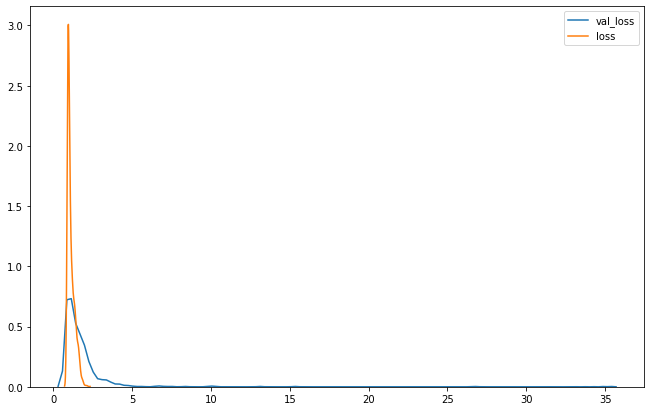

In [ ]:
plt.figure(figsize=(11,7))
sns.kdeplot(df['val_loss'])
sns.kdeplot(df['loss'])

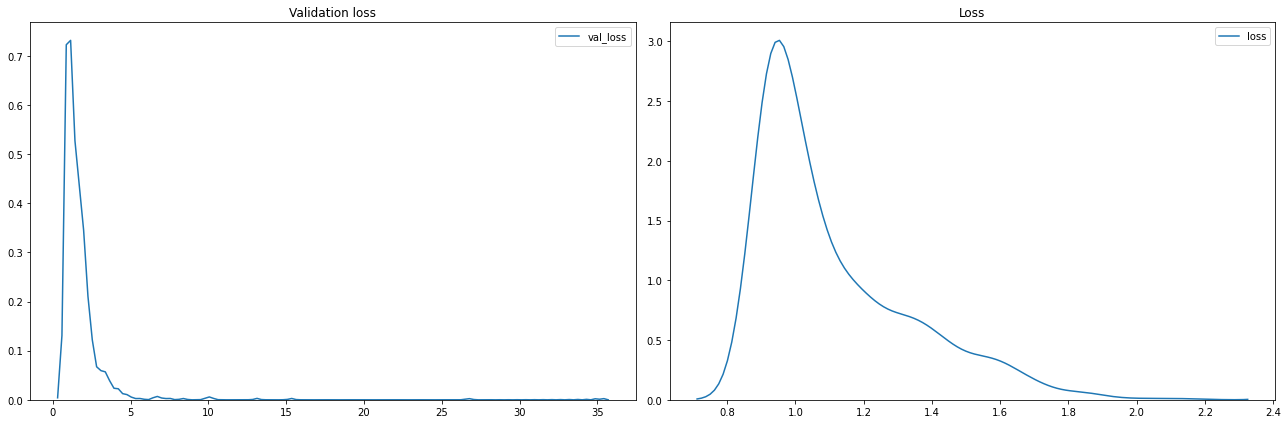

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Validation loss')
sns.kdeplot(df['val_loss'])
plt.subplot(1,2,2)
plt.title('Loss')
sns.kdeplot(df['loss'])
plt.tight_layout()

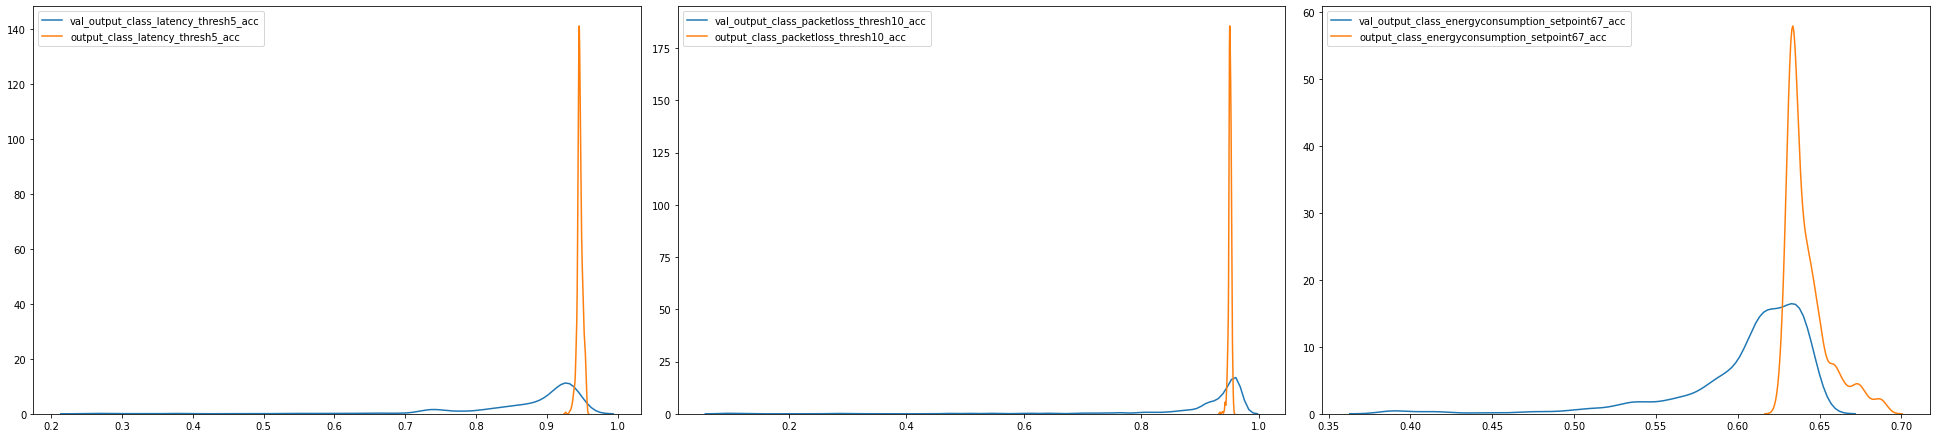

In [ ]:
plot_cols(acc_cols, df)

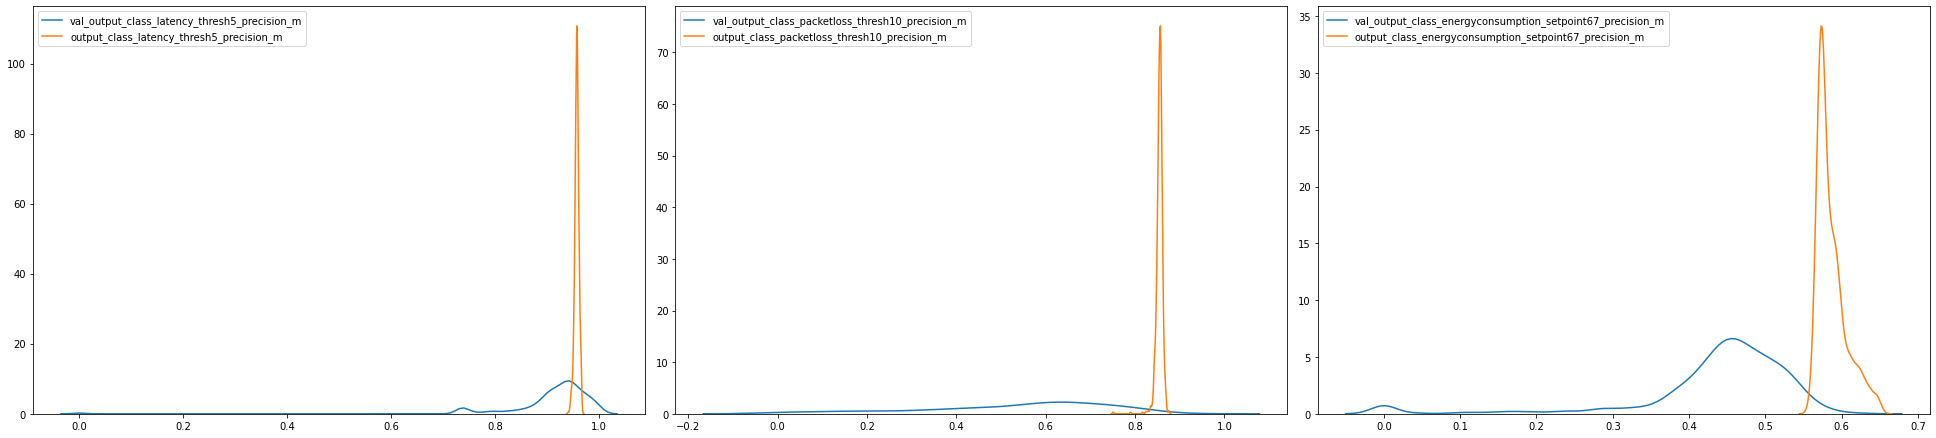

In [ ]:
plot_cols(prec_cols, df)

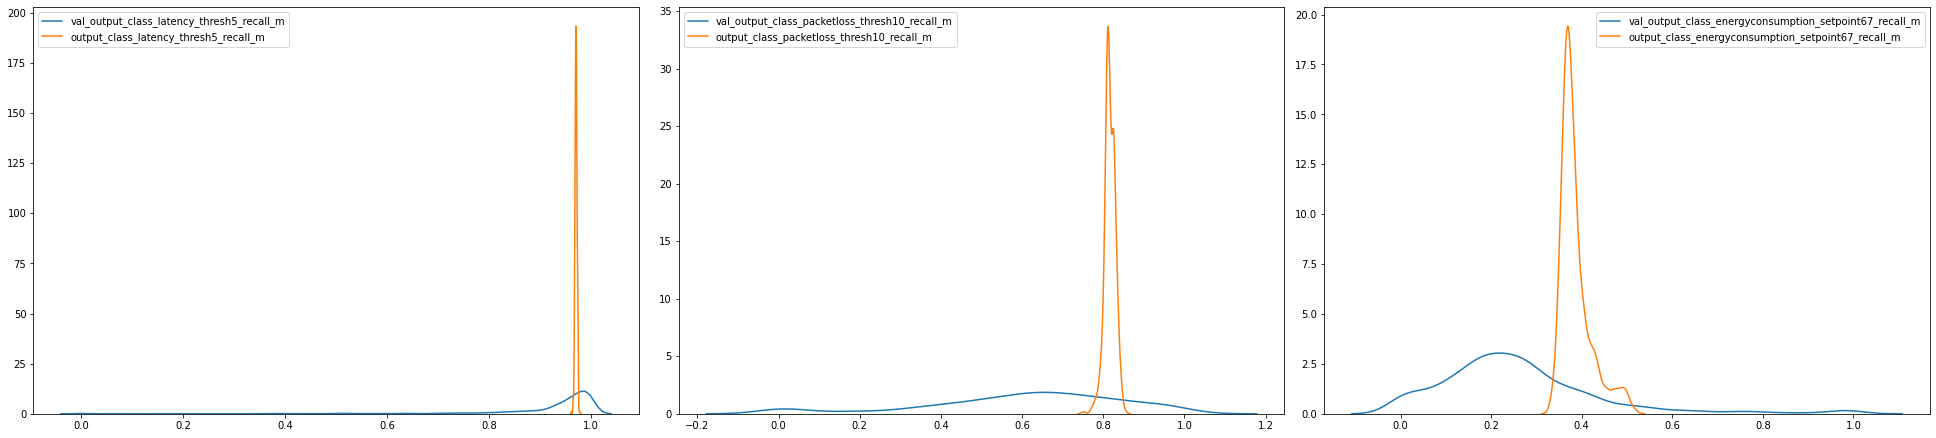

In [ ]:
plot_cols(rec_cols, df)

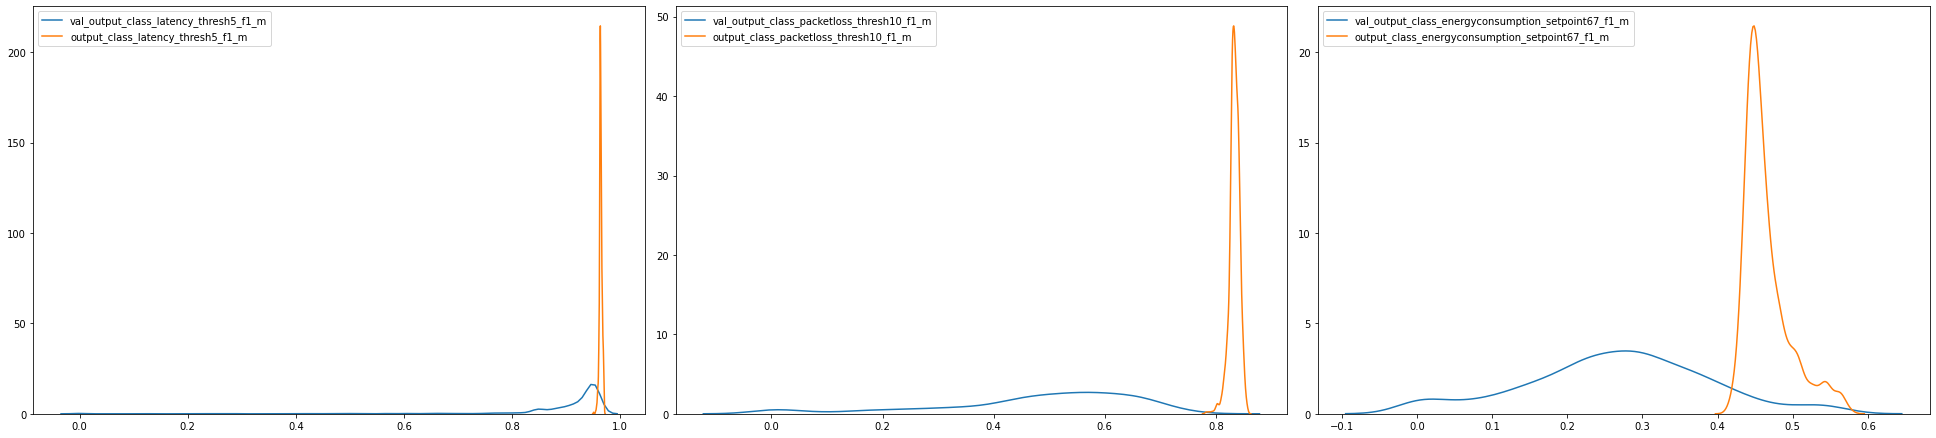

In [ ]:
plot_cols(f1_cols, df)

In [ ]:
df[df['val_loss'] == min(df['val_loss'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
179,179,27,0.879526,0.133399,0.080623,0.635836,0.938436,0.955481,0.94845,0.964312,0.965007,0.537367,0.683326,0.478374,0.64209,0.269799,0.495624,0.229932,0.898776,0.116865,0.11278,0.638797,0.94582,0.963671,0.95581,0.971926,0.950762,0.833794,0.852815,0.819486,0.634727,0.440632,0.578221,0.357448,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."


In [ ]:
df.sort_values('val_loss')[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
179,179,27,0.879526,0.133399,0.080623,0.635836,0.938436,0.955481,0.948450,0.964312,0.965007,0.537367,0.683326,0.478374,0.642090,0.269799,0.495624,0.229932,0.898776,0.116865,0.112780,0.638797,0.945820,0.963671,0.955810,0.971926,0.950762,0.833794,0.852815,0.819486,0.634727,0.440632,0.578221,0.357448,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
227,227,26,0.879982,0.136314,0.082094,0.635439,0.936849,0.952481,0.976834,0.930895,0.964071,0.537852,0.635315,0.492165,0.640747,0.277750,0.474940,0.243556,0.892994,0.115250,0.112319,0.638962,0.946025,0.963846,0.955401,0.972697,0.950840,0.832832,0.859292,0.811300,0.634346,0.443668,0.576644,0.361943,512,"[30, 40, 15, 5]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
8,8,24,0.883781,0.138026,0.079544,0.633903,0.938883,0.956432,0.938462,0.976426,0.965942,0.537050,0.672970,0.471856,0.647664,0.281432,0.486247,0.263174,0.899639,0.115532,0.112919,0.638819,0.946777,0.964149,0.960604,0.967874,0.950830,0.834101,0.853308,0.818932,0.634551,0.454526,0.572758,0.377674,512,"[20, 10, 5]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
77,77,16,0.883902,0.132441,0.083776,0.637705,0.939372,0.955584,0.958560,0.954475,0.963908,0.506966,0.670580,0.431045,0.636963,0.305690,0.479082,0.252607,0.904537,0.119329,0.114068,0.640566,0.945254,0.963273,0.955305,0.971683,0.950176,0.830798,0.856077,0.810714,0.633828,0.440281,0.576417,0.357372,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
5,5,13,0.886664,0.136501,0.080938,0.635555,0.939128,0.955118,0.961459,0.950617,0.965617,0.511771,0.652934,0.454977,0.635579,0.148815,0.321353,0.149764,0.908380,0.118879,0.114570,0.640976,0.945439,0.963383,0.956488,0.970646,0.949570,0.828957,0.850989,0.811145,0.632559,0.446474,0.570971,0.368170,512,"[20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
371,371,28,0.886802,0.133650,0.084358,0.635863,0.940145,0.959045,0.942682,0.976607,0.964478,0.620799,0.752338,0.569584,0.642415,0.258957,0.536943,0.224702,0.896175,0.114007,0.111000,0.637195,0.947061,0.964472,0.958408,0.970734,0.951680,0.836873,0.856981,0.819626,0.636680,0.461829,0.575621,0.386074,1028,"[30, 10, 4]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
29,29,17,0.887045,0.13167

#### Check other metrics

Accuracy

In [ ]:
print(acc_cols)

['val_output_class_latency_thresh5_acc', 'val_output_class_packetloss_thresh10_acc', 'val_output_class_energyconsumption_setpoint67_acc', 'output_class_latency_thresh5_acc', 'output_class_packetloss_thresh10_acc', 'output_class_energyconsumption_setpoint67_acc']


In [ ]:
df[df['val_output_class_latency_thresh5_acc'] == min(df['val_output_class_latency_thresh5_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
105,105,4,15.320927,14.153877,0.317142,0.685147,0.263468,0.0,0.0,0.0,0.912231,0.000000,0.000000,0.000000,0.612671,0.095296,0.345159,0.067907,1.080625,0.125293,0.121310,0.641498,0.943320,0.961981,0.954529,0.969909,0.947119,0.820369,0.846511,0.799837,0.631338,0.439172,0.570270,0.359259,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
177,177,5,4.043686,2.953619,0.252853,0.693428,0.263468,0.0,0.0,0.0,0.891398,0.230903,0.305596,0.315142,0.613118,0.000000,0.000000,0.000000,1.041546,0.124000,0.119816,0.641369,0.944082,0.962630,0.951617,0.974144,0.948184,0.822132,0.857310,0.793793,0.632080,0.437180,0.572321,0.354745,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
297,297,6,8.358637,7.178032,0.256322,0.768359,0.263468,0.0,0.0,0.0,0.875081,0.517920,0.369767,0.906029,0.419637,0.537461,0.397447,0.901169,1.050457,0.120010,0.117124,0.639178,0.945039,0.962926,0.960958,0.965072,0.948936,0.827995,0.845353,0.813982,0.634600,0.447492,0.575128,0.366979,1028,"[20, 10, 5]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
579,579,6,7.479293,6.306760,0.306659,0.724756,0.263468,0.0,0.0,0.0,0.912231,0.000000,0.000000,0.000000,0.613118,0.000000,0.000000,0.000000,1.018292,0.120061,0.115463,0.639621,0.945342,0.963354,0.955286,0.971714,0.950088,0.831856,0.850393,0.815657,0.635000,0.445294,0.576767,0.363949,2056,"[20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
675,675,6,10.207682,9.126341,0.217732,0.691244,0.263468,0.0,0.0,0.0,0.912231,0.000000,0.000000,0.000000,0.534220,0.297944,0.414417,0.317652,1.065047,0.122090,0.116174,0.640971,0.944150,0.962603,0.954865,0.970612,0.949580,0.829215,0.852944,0.808741,0.631553,0.443616,0.569794,0.364991,2056,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)


In [ ]:
df[df['val_output_class_packetloss_thresh10_acc'] == min(df['val_output_class_packetloss_thresh10_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
273,273,4,26.721189,0.963495,24.845140,0.701195,0.541016,0.515316,0.995204,0.387885,0.087769,0.145391,0.087769,0.854167,0.526286,0.536038,0.419330,0.764977,1.138519,0.125358,0.121765,0.641286,0.943311,0.962024,0.953352,0.971173,0.946514,0.816655,0.849326,0.792679,0.631904,0.445137,0.569687,0.367343,512,"[30, 40, 15, 5]","[180, 240, 120, 80, 25]",30,0.002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
339,339,6,35.118010,1.389135,32.840343,0.752525,0.615519,0.642338,0.979935,0.495461,0.087769,0.151549,0.088771,0.958333,0.386882,0.549568,0.387380,1.000000,1.009021,0.123717,0.119379,0.642337,0.943418,0.962048,0.955385,0.969064,0.948438,0.824842,0.850262,0.804184,0.630313,0.444263,0.566406,0.368695,1028,"[20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
603,603,7,9.895745,0.287487,8.798878,0.669289,0.861898,0.911922,0.856808,0.975228,0.087769,0.154352,0.088346,1.000000,0.616903,0.024994,0.181999,0.014027,1.033006,0.120032,0.115307,0.640507,0.944990,0.963006,0.957719,0.968535,0.950439,0.832684,0.851895,0.816382,0.632246,0.442110,0.571682,0.361215,2056,"[20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)


In [ ]:
df[df['val_output_class_energyconsumption_setpoint67_acc'] == min(df['val_output_class_energyconsumption_setpoint67_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
243,243,7,13.108383,0.794085,11.334129,0.900809,0.736613,0.843388,0.736587,1.000000,0.098226,0.145437,0.087792,0.854167,0.386882,0.548216,0.386882,1.000000,0.971899,0.125496,0.120387,0.642469,0.943682,0.962264,0.953931,0.971086,0.947773,0.821404,0.853806,0.796917,0.632109,0.434991,0.573264,0.352193,512,"[30, 40, 15, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
339,339,6,35.118010,1.389135,32.840343,0.752525,0.615519,0.642338,0.979935,0.495461,0.087769,0.151549,0.088771,0.958333,0.386882,0.549568,0.387380,1.000000,1.009021,0.123717,0.119379,0.642337,0.943418,0.962048,0.955385,0.969064,0.948438,0.824842,0.850262,0.804184,0.630313,0.444263,0.566406,0.368695,1028,"[20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
507,507,9,4.571058,3.502462,0.164010,0.845638,0.485270,0.458414,1.000000,0.299628,0.925496,0.167564,0.623737,0.098738,0.386882,0.549568,0.387380,1.000000,0.953071,0.120640,0.115569,0.641077,0.944297,0.962679,0.954839,0.970921,0.949814,0.829619,0.855932,0.807575,0.632647,0.441015,0.572723,0.360126,1028,"[30, 40, 15, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
822,822,15,6.617818,4.958633,0.643042,0.898618,0.368774,0.248195,1.000000,0.142566,0.748657,0.354506,0.219601,1.000000,0.386882,0.550208,0.387565,0.999897,0.999965,0.125663,0.119615,0.638466,0.942021,0.961061,0.954503,0.967897,0.947920,0.823173,0.849047,0.801681,0.634971,0.448660,0.575872,0.368458,2056,"[30, 40, 15, 5]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)


In [ ]:
df.sort_values('val_output_class_latency_thresh5_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
217,217,17,0.983183,0.127973,0.172147,0.638395,0.943766,0.959233,0.953397,0.966566,0.929118,0.525761,0.415781,0.771586,0.642578,0.208884,0.412550,0.189524,0.920101,0.120325,0.114646,0.640374,0.944541,0.962795,0.955968,0.970055,0.950039,0.829202,0.860404,0.804482,0.633584,0.443996,0.574668,0.363678,512,"[30, 40, 15, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
125,125,16,0.915876,0.141871,0.097212,0.634307,0.942790,0.958578,0.952038,0.966728,0.959758,0.440496,0.642700,0.348200,0.638143,0.289707,0.470324,0.265593,0.922730,0.121484,0.116164,0.642704,0.944033,0.962446,0.955113,0.970214,0.949424,0.828167,0.853010,0.808462,0.628789,0.438294,0.565066,0.361148,512,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
194,194,15,0.937161,0.132205,0.103222,0.636467,0.942546,0.958263,0.955621,0.962158,0.959880,0.439354,0.660591,0.360181,0.638713,0.237120,0.531829,0.191707,0.945268,0.121683,0.115907,0.641259,0.944111,0.962617,0.952728,0.973090,0.949512,0.828283,0.854650,0.807467,0.632217,0.439332,0.573215,0.357823,512,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
170,170,18,0.915193,0.129345,0.083321,0.634272,0.941895,0.957283,0.960842,0.954966,0.963867,0.568682,0.589927,0.578978,0.644084,0.224963,0.420268,0.189818,0.945913,0.120235,0.115506,0.641119,0.944844,0.963000,0.955319,0.971161,0.949629,0.827972,0.858909,0.803267,0.631914,0.436705,0.572500,0.354465,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
271,271,10,0.959399,0.129321,0.133198,0.642499,0.941772,0.957109,0.960044,0.955460,0.943197,0.296661,0.679776,0.199766,0.631917,0.113445,0.324951,0.097520,0.938746,0.123055,0.118879,0.641506,0.944707,0.962760,0.959330,0.966521,0.948340,0.824599,0.849214,0.807304,0.632285,0.438271,0.572996,0.357072,512,"[30, 40, 15, 5]","[180, 240, 120, 80, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
98,98,16,0.919305,0.128263,0.083630,0.638612,0.941691,0.957552,0.958795,0.957527,0.964030,0.599840,0.633420,0.615563,0.636312,0.246599,0.343345,0.238681,0.946420,0.119647,0.115857,0.640967,0.944844,0.962957,0.956636,0.969681,0.949678,0.829270,0.853712,0.810302,0.632568,0.448193,0.570307,0.370637,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=Tr

In [ ]:
df.sort_values('val_output_class_packetloss_thresh10_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
539,539,30,0.896621,0.139703,0.078512,0.641341,0.940145,0.958580,0.952441,0.965073,0.967651,0.665201,0.708497,0.657916,0.640218,0.265752,0.513157,0.205969,0.896453,0.113600,0.110206,0.634775,0.947041,0.964355,0.959918,0.968969,0.951299,0.835096,0.857431,0.816008,0.639170,0.457009,0.583035,0.376755,1028,"[30, 40, 15, 5]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
650,650,10,1.001506,0.209089,0.078921,0.642983,0.916667,0.946147,0.902168,0.995674,0.967651,0.734099,0.843044,0.688482,0.626139,0.091031,0.428011,0.061132,0.953619,0.121171,0.118494,0.641756,0.944746,0.962932,0.956356,0.969720,0.948516,0.824552,0.852467,0.800236,0.630781,0.435143,0.570509,0.352727,2056,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
796,796,20,0.927253,0.169324,0.078635,0.643897,0.917887,0.946888,0.905001,0.993156,0.967163,0.692433,0.745471,0.684324,0.634644,0.350784,0.503048,0.369997,0.905049,0.115987,0.113002,0.639700,0.946387,0.963970,0.958437,0.969688,0.950772,0.832890,0.857998,0.811139,0.633896,0.447617,0.574129,0.367819,2056,"[30, 40, 15, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
488,488,17,0.927568,0.145608,0.082307,0.643332,0.936727,0.956640,0.941563,0.973468,0.966756,0.692694,0.824681,0.632317,0.637004,0.265804,0.525917,0.204965,0.931262,0.119281,0.115300,0.639509,0.945195,0.963118,0.958079,0.968431,0.950010,0.830131,0.856181,0.808136,0.633564,0.445507,0.573225,0.365361,1028,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
818,818,13,1.020016,0.196021,0.096859,0.641099,0.920329,0.948371,0.904583,0.997094,0.966553,0.679847,0.771440,0.640095,0.627889,0.101755,0.439620,0.067874,0.971689,0.123721,0.117370,0.642136,0.943643,0.962235,0.954431,0.970326,0.949385,0.828381,0.852827,0.806511,0.631904,0.439957,0.571754,0.358560,2056,"[30, 40, 15, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
26,26,12,0.932415,0.141115,0.078224,0.641211,0.937134,0.955418,0.934364,0.978918,0.966553,0.535509,0.637497,0.491569,0.634440,0.310982,0.481152,0.273717,0.952232,0.122178,0.115948,0.641605,0.944092,0.962599,0.953048,0.972660,0.949209,0.827375,0.852251,0.807396,0.632031,0.446455,0.569542,0.369179,512,"[20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_

In [ ]:
df.sort_values('val_output_class_energyconsumption_setpoint67_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
8,8,24,0.883781,0.138026,0.079544,0.633903,0.938883,0.956432,0.938462,0.976426,0.965942,0.537050,0.672970,0.471856,0.647664,0.281432,0.486247,0.263174,0.899639,0.115532,0.112919,0.638819,0.946777,0.964149,0.960604,0.967874,0.950830,0.834101,0.853308,0.818932,0.634551,0.454526,0.572758,0.377674,512,"[20, 10, 5]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
364,364,16,0.890999,0.145228,0.078998,0.633904,0.931925,0.954444,0.922166,0.989700,0.966431,0.662850,0.725451,0.639002,0.646810,0.322932,0.552628,0.312169,0.907314,0.118313,0.113953,0.640137,0.945371,0.963315,0.957279,0.969645,0.950332,0.831013,0.859258,0.807945,0.633389,0.439726,0.575001,0.357450,1028,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
317,317,13,0.909506,0.133599,0.092574,0.634256,0.939941,0.958794,0.943820,0.974779,0.960693,0.655527,0.633541,0.726852,0.646159,0.269878,0.555452,0.244183,0.927226,0.118969,0.115040,0.641830,0.945850,0.963634,0.958896,0.968549,0.949717,0.828639,0.857563,0.804423,0.633018,0.450007,0.570514,0.372254,1028,"[20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
320,320,13,0.950410,0.152759,0.101049,0.635692,0.933797,0.955377,0.928859,0.984009,0.956299,0.646589,0.602803,0.744173,0.645223,0.294581,0.535988,0.257493,0.935241,0.117884,0.114384,0.639772,0.945293,0.963294,0.957248,0.969589,0.950195,0.830890,0.854699,0.810378,0.633066,0.450386,0.570487,0.372926,1028,"[20, 10, 5]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
529,529,12,0.992018,0.197260,0.083181,0.637031,0.927287,0.947789,0.983087,0.915907,0.965535,0.634096,0.735707,0.577510,0.645182,0.298811,0.528155,0.285700,0.958348,0.124533,0.116811,0.641010,0.943281,0.961966,0.954464,0.969932,0.949131,0.827637,0.852346,0.807247,0.632012,0.440469,0.571873,0.360010,1028,"[30, 40, 15, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
370,370,18,0.947403,0.147951,0.126496,0.635916,0.932536,0.954232,0.932332,0.978089,0.941895,0.681185,0.605444,0.838569,0.645182,0.254931,0.450214,0.229674,0.905463,0.116897,0.111444,0.638607,0.946123,0.963798,0.956420,0.971477,0.952012,0.837451,0.860692,0.817615,0.635098,0.451355,0.574694,0.373607,1028,"[30, 10, 4]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
29,29,17,0.8870

F1-score

In [ ]:
print(f1_cols)

['val_output_class_latency_thresh5_f1_m', 'val_output_class_packetloss_thresh10_f1_m', 'val_output_class_energyconsumption_setpoint67_f1_m', 'output_class_latency_thresh5_f1_m', 'output_class_packetloss_thresh10_f1_m', 'output_class_energyconsumption_setpoint67_f1_m']


In [ ]:
df[df['val_output_class_latency_thresh5_f1_m'] == min(df['val_output_class_latency_thresh5_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
105,105,4,15.320927,14.153877,0.317142,0.685147,0.263468,0.0,0.0,0.0,0.912231,0.000000,0.000000,0.000000,0.612671,0.095296,0.345159,0.067907,1.080625,0.125293,0.121310,0.641498,0.943320,0.961981,0.954529,0.969909,0.947119,0.820369,0.846511,0.799837,0.631338,0.439172,0.570270,0.359259,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
177,177,5,4.043686,2.953619,0.252853,0.693428,0.263468,0.0,0.0,0.0,0.891398,0.230903,0.305596,0.315142,0.613118,0.000000,0.000000,0.000000,1.041546,0.124000,0.119816,0.641369,0.944082,0.962630,0.951617,0.974144,0.948184,0.822132,0.857310,0.793793,0.632080,0.437180,0.572321,0.354745,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
297,297,6,8.358637,7.178032,0.256322,0.768359,0.263468,0.0,0.0,0.0,0.875081,0.517920,0.369767,0.906029,0.419637,0.537461,0.397447,0.901169,1.050457,0.120010,0.117124,0.639178,0.945039,0.962926,0.960958,0.965072,0.948936,0.827995,0.845353,0.813982,0.634600,0.447492,0.575128,0.366979,1028,"[20, 10, 5]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
579,579,6,7.479293,6.306760,0.306659,0.724756,0.263468,0.0,0.0,0.0,0.912231,0.000000,0.000000,0.000000,0.613118,0.000000,0.000000,0.000000,1.018292,0.120061,0.115463,0.639621,0.945342,0.963354,0.955286,0.971714,0.950088,0.831856,0.850393,0.815657,0.635000,0.445294,0.576767,0.363949,2056,"[20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
675,675,6,10.207682,9.126341,0.217732,0.691244,0.263468,0.0,0.0,0.0,0.912231,0.000000,0.000000,0.000000,0.534220,0.297944,0.414417,0.317652,1.065047,0.122090,0.116174,0.640971,0.944150,0.962603,0.954865,0.970612,0.949580,0.829215,0.852944,0.808741,0.631553,0.443616,0.569794,0.364991,2056,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)


In [ ]:
df[df['val_output_class_packetloss_thresh10_f1_m'] == min(df['val_output_class_packetloss_thresh10_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
27,27,5,3.715342,2.233705,0.662220,0.718049,0.736532,0.843349,0.736532,1.000000,0.912231,0.0,0.0,0.0,0.613118,0.000000,0.000000,0.000000,0.997514,0.124210,0.122712,0.642580,0.943711,0.962311,0.952956,0.972140,0.946670,0.818485,0.843103,0.800334,0.630205,0.433937,0.569071,0.352158,512,"[20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
51,51,4,1.941203,0.687663,0.493179,0.641512,0.813436,0.882960,0.795287,0.999943,0.912231,0.0,0.0,0.0,0.642456,0.258580,0.470856,0.236277,1.021730,0.129051,0.125546,0.644074,0.941758,0.961019,0.951426,0.971127,0.945625,0.814621,0.844306,0.793703,0.627832,0.427361,0.566009,0.346138,512,"[20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
81,81,4,3.143158,1.264843,0.690073,1.050903,0.777262,0.863956,0.766024,1.000000,0.912231,0.0,0.0,0.0,0.613118,0.000000,0.000000,0.000000,1.035847,0.123495,0.119556,0.641741,0.944434,0.962724,0.955542,0.970346,0.948545,0.826315,0.846858,0.812770,0.630635,0.443032,0.567238,0.366255,512,"[30, 10, 4]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
99,99,6,3.428745,2.158179,0.524060,0.649508,0.736532,0.843349,0.736532,1.000000,0.912231,0.0,0.0,0.0,0.638387,0.180838,0.369058,0.159087,1.015603,0.128002,0.121056,0.642549,0.941445,0.960850,0.949975,0.972340,0.947705,0.822303,0.847918,0.802831,0.629687,0.439267,0.566942,0.360409,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
105,105,4,15.320927,14.153877,0.317142,0.685147,0.263468,0.000000,0.000000,0.000000,0.912231,0.0,0.0,0.0,0.612671,0.095296,0.345159,0.067907,1.080625,0.125293,0.121310,0.641498,0.943320,0.961981,0.954529,0.969909,0.947119,0.820369,0.846511,0.799837,0.631338,0.439172,0.570270,0.359259,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
123,123,4,4.276983,2.538858,0.794411,0.809131,0.629842,0.650327,1.000000,0.487102,0.912231,0.0,0.0,0.0,0.613118,0.000000,0.000000,0.000000,1.042994,0.130331,0.124263,0.643642,0.941289,0.960692,0.952059,0.969861,0.945840,0.815822,0.841904,0.797282,0.629346,0.432904,0.569054,0.354245,512,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
192,192,5,3.437907,1.867735,0.666140,0.786169,0.736532,0.843349,0.736532,1.000000,0.912231,0.0,0.0,0.0,0.613118,0.000000,0.000000,0.000000,1.039758,0.140864,0.134983,0.644989,0.937842,0.958449,0.947689,0.969905,0.942070,0.800190,0.838929,0.771844,0.626494,0.438758,0.

In [ ]:
df[df['val_output_class_energyconsumption_setpoint67_f1_m'] == min(df['val_output_class_energyconsumption_setpoint67_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
27,27,5,3.715342,2.233705,0.662220,0.718049,0.736532,0.843349,0.736532,1.000000,0.912231,0.000000,0.000000,0.000000,0.613118,0.0,0.0,0.0,0.997514,0.124210,0.122712,0.642580,0.943711,0.962311,0.952956,0.972140,0.946670,0.818485,0.843103,0.800334,0.630205,0.433937,0.569071,0.352158,512,"[20, 10, 5]","[200, 100, 50, 25]",30,0.0050,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
57,57,5,1.781376,0.263330,0.505831,0.882969,0.883423,0.912092,0.948253,0.885248,0.912272,0.000174,0.020833,0.000087,0.613118,0.0,0.0,0.0,1.033418,0.124391,0.120254,0.642238,0.943545,0.962263,0.951465,0.973657,0.948232,0.824014,0.850797,0.804075,0.630791,0.450141,0.566023,0.375680,512,"[20, 10, 5]","[180, 240, 120, 80, 25]",30,0.0020,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
81,81,4,3.143158,1.264843,0.690073,1.050903,0.777262,0.863956,0.766024,1.000000,0.912231,0.000000,0.000000,0.000000,0.613118,0.0,0.0,0.0,1.035847,0.123495,0.119556,0.641741,0.944434,0.962724,0.955542,0.970346,0.948545,0.826315,0.846858,0.812770,0.630635,0.443032,0.567238,0.366255,512,"[30, 10, 4]","[100, 50, 25]",30,0.0020,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
123,123,4,4.276983,2.538858,0.794411,0.809131,0.629842,0.650327,1.000000,0.487102,0.912231,0.000000,0.000000,0.000000,0.613118,0.0,0.0,0.0,1.042994,0.130331,0.124263,0.643642,0.941289,0.960692,0.952059,0.969861,0.945840,0.815822,0.841904,0.797282,0.629346,0.432904,0.569054,0.354245,512,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.0050,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
129,129,7,1.714907,0.450163,0.419994,0.754360,0.890096,0.923801,0.891211,0.961734,0.913086,0.004362,0.104167,0.002288,0.613118,0.0,0.0,0.0,0.987399,0.123497,0.120744,0.641661,0.943584,0.962151,0.954702,0.970069,0.947734,0.823223,0.846340,0.806544,0.630645,0.439749,0.568989,0.360679,512,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.0020,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
147,147,5,3.961325,1.764907,0.298424,1.785908,0.736532,0.843349,0.736532,1.000000,0.872070,0.412549,0.292139,0.824275,0.613118,0.0,0.0,0.0,0.979193,0.126647,0.118037,0.641749,0.942432,0.961375,0.954072,0.969231,0.948779,0.825682,0.854063,0.804647,0.631436,0.437548,0.570876,0.356970,512,"[40, 20, 10, 5]","[100, 50, 25]",30,0.0050,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
177,177,5,4.043686,2.953619,0.252853,0.693428,0.263468,0.000000,0.000000,0.000000,0.891398,0.230903,0.305596,0.315142,0.613118,0.0,0.0,0.0,1.041546,0.124000,0.119816,0.641369,0.944082,0.962630,0.951617,0.974144,0.948184,0.822132,0.857310,0.793793,0.632080,0

In [ ]:
df.sort_values('val_output_class_latency_thresh5_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
821,821,18,0.986205,0.142956,0.160380,0.635877,0.940633,0.960291,0.941058,0.980544,0.936442,0.701876,0.609204,0.894530,0.640218,0.219431,0.541270,0.188951,0.919224,0.116403,0.113884,0.639630,0.946074,0.963778,0.957750,0.969969,0.950684,0.833810,0.852948,0.817202,0.634541,0.453643,0.573064,0.375957,2056,"[30, 40, 15, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
727,727,30,0.905152,0.130066,0.090747,0.638886,0.941528,0.960149,0.958291,0.962260,0.962687,0.652255,0.750019,0.645567,0.639282,0.272965,0.525081,0.214135,0.910057,0.114410,0.111410,0.636918,0.947324,0.964612,0.960040,0.969312,0.951572,0.835119,0.863399,0.809839,0.635664,0.450741,0.576967,0.370619,2056,"[40, 20, 10, 5]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
797,797,27,0.889001,0.133094,0.080170,0.640725,0.941203,0.960118,0.952740,0.967912,0.965454,0.709061,0.850102,0.656847,0.641357,0.206311,0.569726,0.149334,0.902264,0.115937,0.111181,0.638778,0.947002,0.964448,0.957609,0.971475,0.951768,0.836523,0.860419,0.815424,0.634521,0.442764,0.576989,0.360189,2056,"[30, 40, 15, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
773,773,17,0.916658,0.139719,0.083467,0.644072,0.940226,0.959868,0.944294,0.976260,0.964152,0.636067,0.791107,0.576737,0.629232,0.157889,0.533092,0.109582,0.923484,0.118980,0.113799,0.641144,0.945332,0.963326,0.956354,0.970570,0.949990,0.831101,0.852057,0.812758,0.632959,0.446218,0.571749,0.366681,2056,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
707,707,23,0.944097,0.137586,0.085035,0.651207,0.940267,0.959781,0.946577,0.973692,0.963420,0.752177,0.807634,0.721178,0.619303,0.363859,0.481711,0.307536,0.924909,0.111064,0.111372,0.630917,0.947666,0.964944,0.957466,0.972661,0.951289,0.833931,0.863512,0.807274,0.643555,0.475725,0.586402,0.400928,2056,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.002,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
653,653,25,0.903433,0.131527,0.099296,0.638798,0.939860,0.959649,0.942773,0.977247,0.957113,0.727286,0.729894,0.803061,0.642008,0.303380,0.517517,0.276138,0.900409,0.114245,0.111223,0.639009,0.946494,0.964095,0.957636,0.970742,0.951387,0.835258,0.859848,0.813227,0.635205,0.438137,0.580125,0.353447,2056,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=T

In [ ]:
df.sort_values('val_output_class_packetloss_thresh10_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
587,587,28,0.949895,0.151376,0.083637,0.657581,0.935547,0.957020,0.935552,0.979639,0.963786,0.756034,0.783387,0.756017,0.613932,0.387947,0.487691,0.354864,0.917474,0.112885,0.110900,0.635024,0.947148,0.964530,0.957892,0.971322,0.951426,0.835518,0.858925,0.814799,0.638652,0.461283,0.580408,0.383199,2056,"[20, 10, 5]","[100, 50, 25]",30,0.0020,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
798,798,15,1.255081,0.389951,0.087824,0.692073,0.849487,0.907063,0.830653,0.999338,0.966024,0.753691,0.798755,0.724582,0.518595,0.534871,0.416322,0.775641,0.963481,0.121008,0.115099,0.637944,0.944580,0.962762,0.957697,0.968016,0.949863,0.829442,0.856623,0.805919,0.635498,0.447493,0.578556,0.366493,2056,"[30, 40, 15, 5]","[100, 50, 25]",30,0.0020,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
707,707,23,0.944097,0.137586,0.085035,0.651207,0.940267,0.959781,0.946577,0.973692,0.963420,0.752177,0.807634,0.721178,0.619303,0.363859,0.481711,0.307536,0.924909,0.111064,0.111372,0.630917,0.947666,0.964944,0.957466,0.972661,0.951289,0.833931,0.863512,0.807274,0.643555,0.475725,0.586402,0.400928,2056,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.0020,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
680,680,26,0.938867,0.145966,0.086407,0.641234,0.938110,0.958526,0.940569,0.977323,0.962850,0.751882,0.711932,0.819169,0.634115,0.342860,0.492489,0.292119,0.925473,0.113780,0.112308,0.632842,0.947070,0.964444,0.958855,0.970233,0.950889,0.834296,0.854414,0.816653,0.642100,0.469353,0.585529,0.392490,2056,"[30, 10, 4]","[200, 100, 50, 25]",30,0.0020,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
853,853,16,1.731843,0.371006,0.098851,0.690031,0.870036,0.918554,0.859737,0.988445,0.961589,0.749228,0.718883,0.789294,0.623169,0.171161,0.463619,0.117451,1.399175,0.104921,0.105753,0.607449,0.952812,0.968254,0.964393,0.972244,0.953818,0.845563,0.857959,0.835121,0.668828,0.525871,0.623981,0.454862,2056,"[30, 40, 15, 5]","[180, 240, 120, 80, 25]",30,0.0005,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
679,679,17,1.001584,0.183449,0.093676,0.638741,0.920939,0.948668,0.905584,0.996479,0.959473,0.744802,0.682341,0.836927,0.642659,0.261548,0.558869,0.221143,0.962420,0.119655,0.116215,0.638290,0.944687,0.962781,0.958787,0.966941,0.949648,0.829193,0.854806,0.807625,0.634355,0.446420,0.575693,0.365505,2056,"[30, 10, 4]","[200, 100, 50, 25]",30,0.0020,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
845,84

In [ ]:
df.sort_values('val_output_class_energyconsumption_setpoint67_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_class_latency_thresh5_loss,val_output_class_packetloss_thresh10_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_packetloss_thresh10_acc,val_output_class_packetloss_thresh10_f1_m,val_output_class_packetloss_thresh10_precision_m,val_output_class_packetloss_thresh10_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_class_latency_thresh5_loss,output_class_packetloss_thresh10_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_packetloss_thresh10_acc,output_class_packetloss_thresh10_f1_m,output_class_packetloss_thresh10_precision_m,output_class_packetloss_thresh10_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,scaler
393,393,5,5.615875,0.288615,4.389258,0.735909,0.880981,0.924507,0.864142,0.996224,0.278605,0.160851,0.094082,0.958333,0.396566,0.550211,0.388866,0.989375,1.107154,0.120642,0.119438,0.639328,0.944893,0.963037,0.954501,0.971895,0.948154,0.825616,0.843056,0.812144,0.633662,0.441095,0.574769,0.358745,1028,"[30, 10, 4]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
822,822,15,6.617818,4.958633,0.643042,0.898618,0.368774,0.248195,1.000000,0.142566,0.748657,0.354506,0.219601,1.000000,0.386882,0.550208,0.387565,0.999897,0.999965,0.125663,0.119615,0.638466,0.942021,0.961061,0.954503,0.967897,0.947920,0.823173,0.849047,0.801681,0.634971,0.448660,0.575872,0.368458,2056,"[30, 40, 15, 5]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
339,339,6,35.118010,1.389135,32.840343,0.752525,0.615519,0.642338,0.979935,0.495461,0.087769,0.151549,0.088771,0.958333,0.386882,0.549568,0.387380,1.000000,1.009021,0.123717,0.119379,0.642337,0.943418,0.962048,0.955385,0.969064,0.948438,0.824842,0.850262,0.804184,0.630313,0.444263,0.566406,0.368695,1028,"[20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
507,507,9,4.571058,3.502462,0.164010,0.845638,0.485270,0.458414,1.000000,0.299628,0.925496,0.167564,0.623737,0.098738,0.386882,0.549568,0.387380,1.000000,0.953071,0.120640,0.115569,0.641077,0.944297,0.962679,0.954839,0.970921,0.949814,0.829619,0.855932,0.807575,0.632647,0.441015,0.572723,0.360126,1028,"[30, 40, 15, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
483,483,5,5.115298,3.496376,0.770305,0.725490,0.305501,0.107537,1.000000,0.057310,0.685872,0.269696,0.164224,0.958333,0.413981,0.549505,0.392706,0.961302,1.038618,0.124896,0.120020,0.642007,0.943125,0.961852,0.954450,0.969571,0.948545,0.824803,0.852991,0.801272,0.630938,0.445053,0.567566,0.367910,1028,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
54,54,8,1.487802,0.347026,0.317371,0.757345,0.859619,0.910256,0.838612,0.999788,0.851807,0.381059,0.255819,0.848382,0.415812,0.549502,0.390492,0.966631,0.959438,0.125744,0.122035,0.642531,0.942852,0.961652,0.955026,0.968766,0.947539,0.821830,0.845974,0.803948,0.630469,0.447758,0.565329,0.372579,512,"[20, 10, 5]","[180, 240, 120, 80, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
819,819,8,2.800140,1.464760,0.477635,0.703471,0.310425,0.118702,1.000000,0.063322,0.912231,0.000000,0.000000,0.000000,0.408651,0.548953,0.3907

### Setup 3

**T1**: LA < 5%  
**S1**: minimize PL  
**O1**: EC == 67 +/- 0.3

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2, l1
from talos.model.early_stopper import early_stopper

# y_train and y_val are dictionaries of {quality: data}
def build_dlaser_pipeline_setup3(x_train, y_train, x_val, y_val, params):
    callback=early_stopper(params['epochs'], monitor='val_loss', mode='moderate')

    dlaser = DLASeR(['packetloss', 'latency', 'energyconsumption'], params['core_params'])
    dlaser.add_theshold_goal('latency', Operator.Min, 5, params['class_params'])
    dlaser.add_optimizataion_goal('packetloss', Operator.Min, params['regr_params'])
    dlaser.add_setpoint_goal('energyconsumption', 67, 0.3, params['class_params'])

    scaler = params['scaler']
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    dlaser.compile(params['optimizer'], params['lr'], extensive_metrics=True)

    out = dlaser.fit_gridsearch(x_train, x_val,
                                y_train, y_val,
                                batch_size=params['batch_size'], epochs=params['epochs'],
                                callback=callback,
                                verbose=False)
    model = dlaser.get_model()

    return out, model

In [ ]:
# Grid options
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
p = {
    'core_params' : [[100,50,25],[200,100,50,25],[180,240,120,80,25]],
    'class_params' : [[20,10,5],[30,10,4],[40,20,10,5]],
    'regr_params' : [[20,10,5],[30,40,15,5],[40,20,10,5]],
    'scaler' : [IDScaler(), MaxAbsScaler(), MinMaxScaler(), StandardScaler()],
    'epochs' : [30],
    'optimizer' : [RMSprop, Adam, Nadam], 
    'lr' : [5e-3, 2e-3, 5e-4, 2e-4],
    'batch_size' : [512, 1028, 2056]
}

In [ ]:
import talos
t = talos.Scan(X[:25*nb_opts], {'packetloss': y_pl[:25*nb_opts], 'latency': y_la[:25*nb_opts], 'energyconsumption' : y_ec[:25*nb_opts]}, # First 25 cycles -> train cycles
               x_val=X[25*nb_opts:], y_val={'packetloss': y_pl[25*nb_opts:], 'latency': y_la[25*nb_opts:], 'energyconsumption' : y_ec[25*nb_opts:]}, # Last 5 cycles -> test cycles
               model=build_dlaser_pipeline_setup3,
               params=p, experiment_name='setup3_deltaIoTv1')


100%|██████████| 1296/1296 [17:00:56<00:00, 47.27s/it]


In [ ]:
t.data.to_csv('gridsearch_setup3_v2.csv')

#### Evaluation

In [ ]:
df = pd.read_csv('gridsearch_setup3_v2.csv')
df.head()

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
0,0,16,1.273779,0.766759,0.178811,0.669061,0.924113,0.942241,0.973606,0.916597,0.579305,0.500383,0.438195,0.623937,0.932842,0.459596,0.131942,0.642855,0.940811,0.960431,0.949736,0.971694,0.630879,0.439440,0.569448,0.359284,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
1,1,16,1.411110,0.885420,0.195791,0.642116,0.920939,0.945044,0.914603,0.982012,0.638143,0.349095,0.497950,0.319732,0.991246,0.497150,0.130364,0.642939,0.942471,0.961278,0.956718,0.966244,0.630195,0.440941,0.567491,0.365502,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
2,2,20,1.146438,0.663303,0.138410,0.641090,0.933757,0.949940,0.981761,0.921494,0.637410,0.282010,0.503459,0.254839,0.954692,0.475646,0.125804,0.643213,0.944316,0.962600,0.956492,0.969030,0.629990,0.443050,0.567261,0.366021,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
3,3,4,13.296508,12.149522,1.204846,0.673162,0.753092,0.848302,0.761072,0.973772,0.611003,0.034233,0.209661,0.021326,1.394120,0.768282,0.163571,0.646997,0.927314,0.951516,0.938925,0.965042,0.624756,0.389380,0.569866,0.299839,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
4,4,7,3.321564,2.743984,0.146785,0.640620,0.931803,0.949704,0.962827,0.940146,0.632731,0.342483,0.505327,0.334365,1.257782,0.677771,0.132802,0.643171,0.940732,0.960286,0.951391,0.969726,0.629736,0.451398,0.562772,0.379798,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

loss_cols = []
acc_cols = []
prec_cols = []
rec_cols = []
f1_cols = []
for col in df.columns:
    if '_loss' in col and col != 'val_loss':
        loss_cols.append(col)
    elif '_acc' in col:
        acc_cols.append(col)
    elif '_precision' in col:
        prec_cols.append(col)
    elif '_recall' in col:
        rec_cols.append(col)
    elif '_f1' in col:
        f1_cols.append(col)
    
print(loss_cols)
print(acc_cols)
print(prec_cols)
print(rec_cols)
print(f1_cols)

['val_output_regr_packetloss_opt_loss', 'val_output_class_latency_thresh5_loss', 'val_output_class_energyconsumption_setpoint67_loss', 'output_regr_packetloss_opt_loss', 'output_class_latency_thresh5_loss', 'output_class_energyconsumption_setpoint67_loss']
['val_output_class_latency_thresh5_acc', 'val_output_class_energyconsumption_setpoint67_acc', 'output_class_latency_thresh5_acc', 'output_class_energyconsumption_setpoint67_acc']
['val_output_class_latency_thresh5_precision_m', 'val_output_class_energyconsumption_setpoint67_precision_m', 'output_class_latency_thresh5_precision_m', 'output_class_energyconsumption_setpoint67_precision_m']
['val_output_class_latency_thresh5_recall_m', 'val_output_class_energyconsumption_setpoint67_recall_m', 'output_class_latency_thresh5_recall_m', 'output_class_energyconsumption_setpoint67_recall_m']
['val_output_class_latency_thresh5_f1_m', 'val_output_class_energyconsumption_setpoint67_f1_m', 'output_class_latency_thresh5_f1_m', 'output_class_energyc

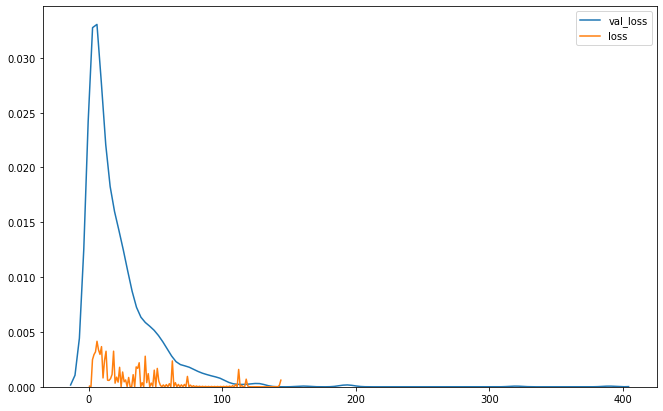

In [ ]:
plt.figure(figsize=(11,7))
sns.kdeplot(df['val_loss'])
sns.kdeplot(df['loss'])

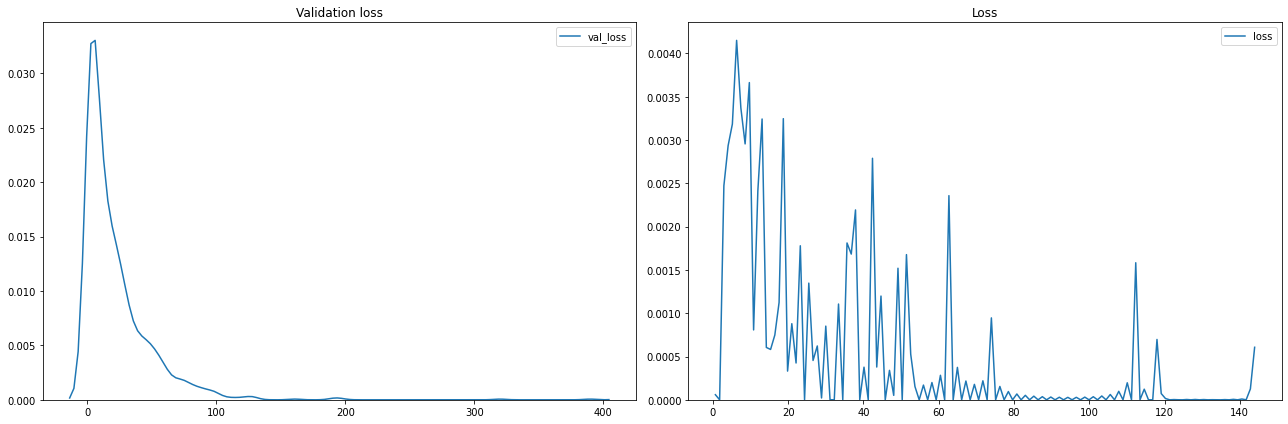

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Validation loss')
sns.kdeplot(df['val_loss'])
plt.subplot(1,2,2)
plt.title('Loss')
sns.kdeplot(df['loss'])
plt.tight_layout()

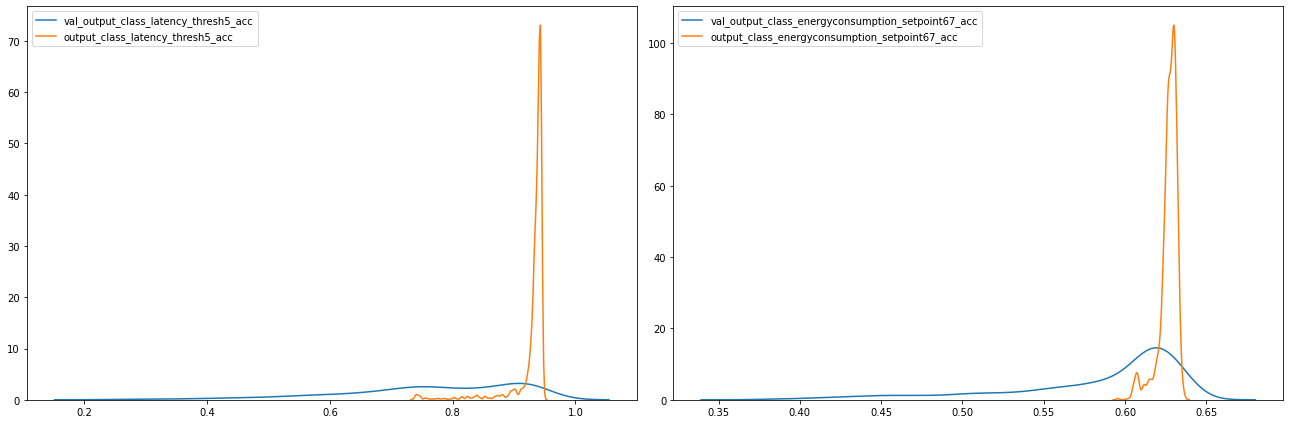

In [ ]:
plot_cols(acc_cols, df)

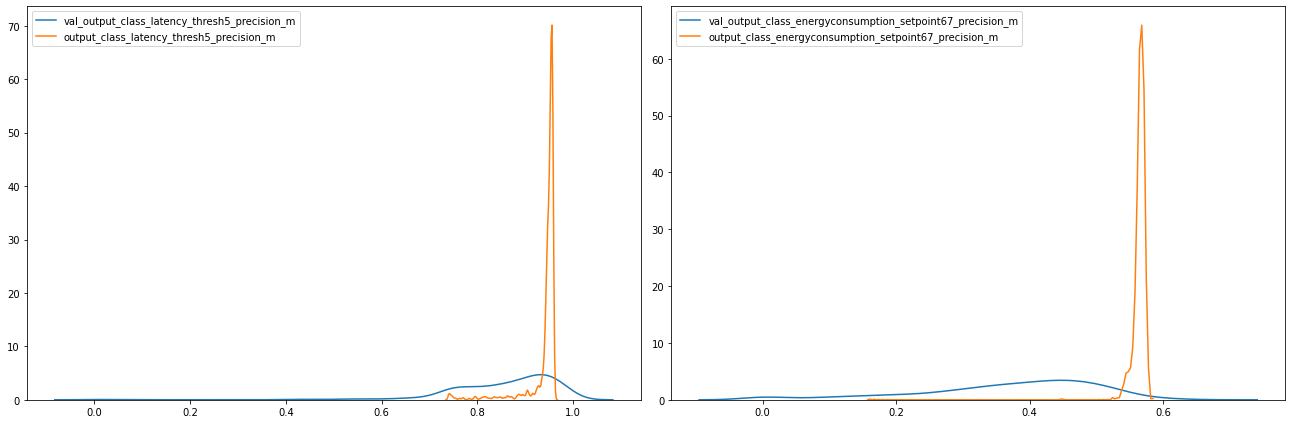

In [ ]:
plot_cols(prec_cols, df)

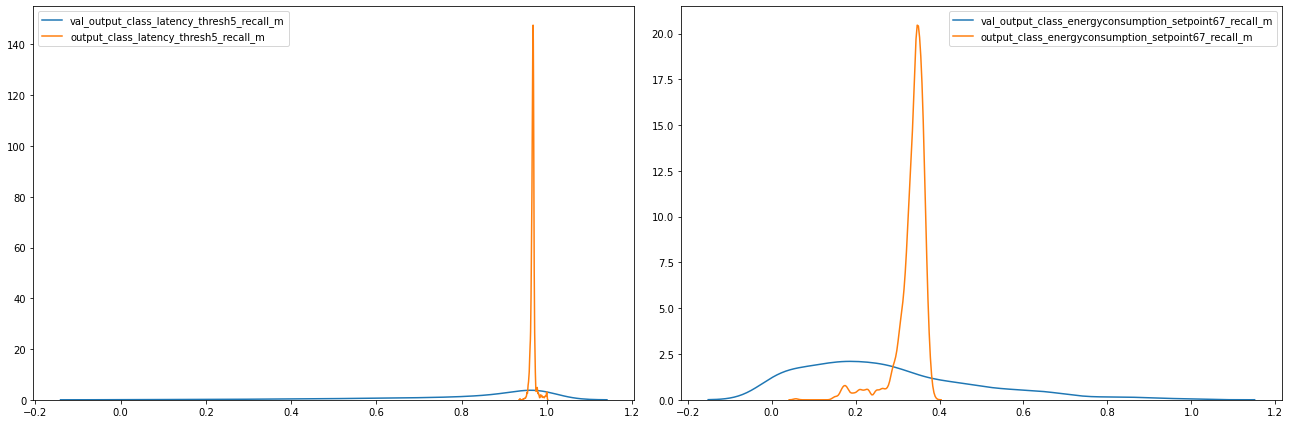

In [ ]:
plot_cols(rec_cols, df)

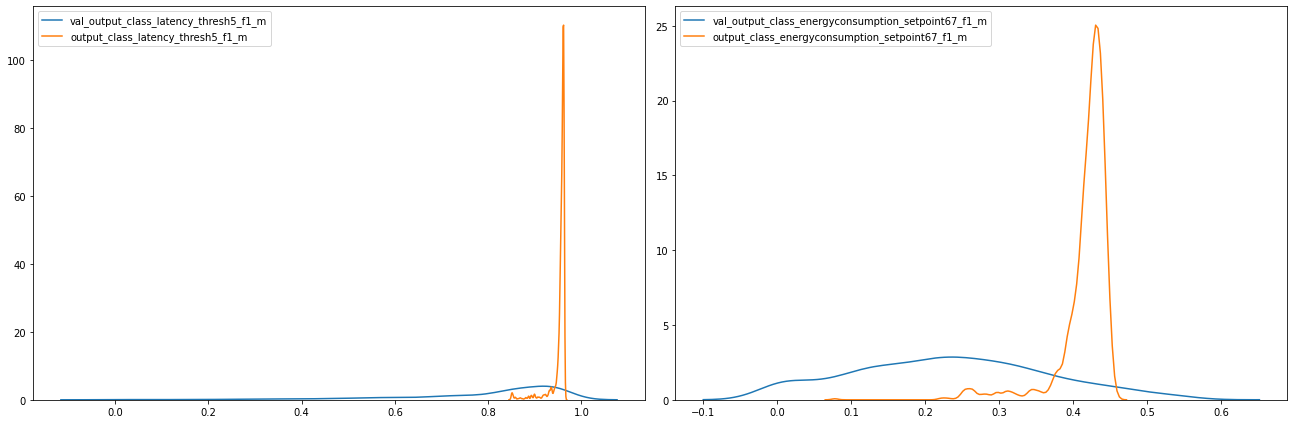

In [ ]:
plot_cols(f1_cols, df)

In [ ]:
df[df['val_loss'] == min(df['val_loss'])]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
97,97,20,1.070009,0.541411,0.136586,0.645595,0.94043,0.956832,0.952846,0.96183,0.635213,0.29833,0.48095,0.257207,0.997255,0.472499,0.126195,0.643202,0.943672,0.962143,0.956516,0.968194,0.630322,0.438518,0.567808,0.358431,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"


In [ ]:
df.sort_values('val_loss')[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
97,97,20,1.070009,0.541411,0.136586,0.645595,0.940430,0.956832,0.952846,0.961830,0.635213,0.298330,0.480950,0.257207,0.997255,0.472499,0.126195,0.643202,0.943672,0.962143,0.956516,0.968194,0.630322,0.438518,0.567808,0.358431,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
13,13,11,1.082950,0.530497,0.141161,0.647736,0.937012,0.955569,0.938490,0.975210,0.627686,0.341996,0.501783,0.323630,1.020705,0.468256,0.131103,0.644027,0.942480,0.961336,0.955725,0.967364,0.630098,0.431492,0.570135,0.349574,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
250,250,22,1.108864,0.572800,0.159864,0.642014,0.925252,0.948773,0.908702,0.994099,0.637614,0.181229,0.430079,0.160711,0.966656,0.444999,0.123149,0.640902,0.943457,0.962018,0.956070,0.968306,0.632314,0.442863,0.571668,0.363367,512,"[40, 20, 10, 5]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
248,248,30,1.111598,0.574646,0.144394,0.661630,0.937581,0.953376,0.970610,0.938160,0.624837,0.198697,0.524413,0.143282,0.947602,0.430562,0.121264,0.640474,0.945107,0.963230,0.954564,0.972329,0.634141,0.440981,0.576330,0.358489,512,"[40, 20, 10, 5]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
467,467,30,1.138580,0.525102,0.178773,0.678600,0.925741,0.948613,0.951313,0.949240,0.607381,0.222369,0.467436,0.199586,1.051241,0.484201,0.122899,0.641036,0.944785,0.962887,0.958123,0.967800,0.630908,0.446068,0.566899,0.368825,1028,"[30, 10, 4]","[100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
230,230,17,1.143172,0.586488,0.156342,0.661795,0.935384,0.953810,0.942801,0.966247,0.613770,0.371583,0.486611,0.357583,1.001119,0.465501,0.122689,0.642171,0.945127,0.963211,0.954743,0.972071,0.630605,0.431894,0.570366,0.349338,512,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
10,10,23,1.143515,0.606455,0.165579,0.682709,0.924845,0.948373,0.908280,0.993757,0.613444,0.015722,0.116715,0.009334,0.942654,0.447440,0.124005,0.641893,0.944023,0.962454,0.955160,0.970159,0.631377,0.439484,0.570996,0.359200,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
2,2,20,1.146438,0.663303,0.138410,0.641090,0.933757,0.949940,0.981761,0.921494,0.637410,0.282010,0.503459,0.254839,0.954692,0.475646,0.125804,0.643213,0.944316,0.962600,0.956492,0.969030,0.629990,0.443050,0.567261,0.366021,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScale

#### Check other metrics

Accuracy

In [ ]:
print(acc_cols)

['val_output_class_latency_thresh5_acc', 'val_output_class_energyconsumption_setpoint67_acc', 'output_class_latency_thresh5_acc', 'output_class_energyconsumption_setpoint67_acc']


In [ ]:
df[df['val_output_class_latency_thresh5_acc'] == min(df['val_output_class_latency_thresh5_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
75,75,5,19.390246,14.399551,8.813808,0.656618,0.263468,0.0,0.0,0.0,0.627197,0.311068,0.521462,0.325045,1.394885,0.732212,0.156332,0.648839,0.932793,0.954819,0.949439,0.960690,0.625479,0.413342,0.564991,0.330667,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
231,231,5,41.608435,28.556566,24.663071,0.746602,0.263468,0.0,0.0,0.0,0.532511,0.352436,0.419299,0.455077,1.224481,0.462905,0.150011,0.646862,0.930322,0.953847,0.934838,0.973972,0.626816,0.423808,0.564005,0.342898,512,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
966,966,10,31.372787,26.964922,6.417763,0.703484,0.263468,0.0,0.0,0.0,0.479411,0.414701,0.334185,0.668569,1.694003,0.495166,0.130891,0.643499,0.941963,0.961091,0.953300,0.969124,0.628955,0.419411,0.570655,0.332323,2056,"[30, 10, 4]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
1224,1224,8,6.705073,4.019471,3.991441,0.673797,0.263468,0.0,0.0,0.0,0.613118,0.000000,0.000000,0.000000,1.480389,0.695776,0.176478,0.660971,0.924531,0.949276,0.943306,0.955672,0.605430,0.263860,0.538698,0.180234,2056,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",MaxAbsScaler(copy=True)


In [ ]:
df[df['val_output_class_energyconsumption_setpoint67_acc'] == min(df['val_output_class_energyconsumption_setpoint67_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
625,625,18,21.378018,19.82967,0.584483,0.792151,0.778849,0.841427,0.894514,0.812441,0.373779,0.429899,0.296155,0.821654,1.647676,0.469292,0.129605,0.643606,0.944268,0.962527,0.958428,0.966806,0.629365,0.422056,0.570401,0.335906,1028,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.0005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"


In [ ]:
df.sort_values('val_output_class_latency_thresh5_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
290,290,8,2.399374,1.777987,0.138742,0.666341,0.942505,0.958094,0.954139,0.963470,0.623128,0.286857,0.494953,0.244459,1.213598,0.593310,0.134356,0.651564,0.941309,0.960666,0.952335,0.969407,0.621660,0.402322,0.557872,0.316983,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
1153,1153,16,1.454857,0.840484,0.162050,0.645606,0.941650,0.960610,0.949676,0.972735,0.625936,0.190013,0.432444,0.129399,1.204629,0.597820,0.134900,0.645198,0.941191,0.960645,0.952211,0.969417,0.627852,0.424686,0.566732,0.343683,2056,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1082,1082,21,1.294910,0.740955,0.132172,0.648682,0.941406,0.960493,0.948253,0.973342,0.624919,0.072046,0.436051,0.054746,1.143596,0.588789,0.128127,0.642547,0.943164,0.961830,0.956467,0.967379,0.630723,0.430634,0.571896,0.347060,2056,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
653,653,11,3.520716,2.951963,0.144002,0.661393,0.940755,0.958671,0.954788,0.963304,0.630249,0.144350,0.607703,0.096313,1.240063,0.669031,0.133009,0.644670,0.941377,0.960690,0.953159,0.968587,0.627441,0.424994,0.565472,0.342985,1028,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
14,14,15,1.857768,1.318547,0.146512,0.644499,0.940552,0.955398,0.975248,0.937713,0.635173,0.315205,0.512669,0.303796,0.981292,0.452059,0.123390,0.641436,0.945039,0.963216,0.953744,0.973103,0.633721,0.443974,0.574328,0.363239,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
97,97,20,1.070009,0.541411,0.136586,0.645595,0.940430,0.956832,0.952846,0.961830,0.635213,0.298330,0.480950,0.257207,0.997255,0.472499,0.126195,0.643202,0.943672,0.962143,0.956516,0.968194,0.630322,0.438518,0.567808,0.358431,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
149,149,12,2.229021,1.660315,0.137585,0.656525,0.940226,0.956340,0.959677,0.955159,0.622111,0.105723,0.469803,0.066912,1.137137,0.566688,0.133473,0.660874,0.941260,0.960594,0.952965,0.968609,0.606650,0.264879,0.543063,0.178819,512,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
433,433,14,1.849266,1.341024,0.138032,0.638103,0.940145,0.957543,0.974015,0.942311,0.635498,0.193885,0.551832,0.139982,0.984214,0.479260,0.134118,0.643575,0.941709,0.960842,0.955987,0.966030,0.627715,0.435035,0.563270,0.357595,1028,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'kera

In [ ]:
df.sort_values('val_output_class_energyconsumption_setpoint67_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
226,226,12,1.320281,0.775956,0.185193,0.635839,0.931152,0.947470,0.984354,0.915102,0.645630,0.300047,0.536167,0.281815,1.001674,0.477974,0.128849,0.642116,0.942520,0.961400,0.955311,0.967865,0.631699,0.442013,0.570835,0.362822,512,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
377,377,14,1.742714,1.132674,0.197511,0.642115,0.923747,0.947201,0.913758,0.986037,0.643026,0.274537,0.558064,0.230075,1.047468,0.459241,0.130409,0.645936,0.942324,0.961315,0.953579,0.969441,0.626729,0.447762,0.556976,0.379095,512,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
379,379,11,1.305083,0.736529,0.172076,0.635759,0.930094,0.951129,0.921273,0.984634,0.642741,0.272392,0.501431,0.239402,1.104484,0.545168,0.134225,0.643949,0.941729,0.960860,0.954257,0.967898,0.628174,0.441074,0.562602,0.364638,512,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
7,7,12,1.200746,0.661264,0.163642,0.648576,0.932821,0.952818,0.928522,0.980531,0.639933,0.239434,0.517299,0.197804,1.036160,0.511564,0.128481,0.643326,0.942676,0.961570,0.953836,0.969791,0.629902,0.449119,0.564068,0.377029,512,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
221,221,16,1.214580,0.691837,0.145277,0.637579,0.934937,0.953105,0.945311,0.964657,0.639933,0.294471,0.526052,0.238479,1.048507,0.532960,0.124840,0.642641,0.943770,0.962404,0.951619,0.973684,0.631299,0.439411,0.570366,0.360082,512,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
95,95,17,1.385229,0.853159,0.140905,0.642022,0.935221,0.953313,0.942470,0.966098,0.639893,0.335692,0.505754,0.291703,1.018159,0.491457,0.127139,0.641327,0.943184,0.961920,0.953749,0.970460,0.633047,0.446631,0.571478,0.368735,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
440,440,12,2.065459,1.515823,0.153602,0.641923,0.930339,0.950536,0.971455,0.931853,0.639323,0.217628,0.588221,0.177716,1.200073,0.667908,0.128485,0.644193,0.943037,0.961805,0.955485,0.968355,0.627842,0.433288,0.563394,0.355230,1028,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
89,89,17,1.333921,0.786214,0.141928,0.640784,0.938395,0.954210,0.967289,0.943017,0.639119,0.262644,0.517414,0.225530,1.005165,0.455639,0.128573,0.642937,0.942754,0.961529,0.956206,0.967168,0.630928,0.441992,0.568467,0.363617,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimi

F1-score

In [ ]:
print(f1_cols)

['val_output_class_latency_thresh5_f1_m', 'val_output_class_energyconsumption_setpoint67_f1_m', 'output_class_latency_thresh5_f1_m', 'output_class_energyconsumption_setpoint67_f1_m']


In [ ]:
df[df['val_output_class_latency_thresh5_f1_m'] == min(df['val_output_class_latency_thresh5_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
75,75,5,19.390246,14.399551,8.813808,0.656618,0.263468,0.0,0.0,0.0,0.627197,0.311068,0.521462,0.325045,1.394885,0.732212,0.156332,0.648839,0.932793,0.954819,0.949439,0.960690,0.625479,0.413342,0.564991,0.330667,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
231,231,5,41.608435,28.556566,24.663071,0.746602,0.263468,0.0,0.0,0.0,0.532511,0.352436,0.419299,0.455077,1.224481,0.462905,0.150011,0.646862,0.930322,0.953847,0.934838,0.973972,0.626816,0.423808,0.564005,0.342898,512,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
966,966,10,31.372787,26.964922,6.417763,0.703484,0.263468,0.0,0.0,0.0,0.479411,0.414701,0.334185,0.668569,1.694003,0.495166,0.130891,0.643499,0.941963,0.961091,0.953300,0.969124,0.628955,0.419411,0.570655,0.332323,2056,"[30, 10, 4]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
1224,1224,8,6.705073,4.019471,3.991441,0.673797,0.263468,0.0,0.0,0.0,0.613118,0.000000,0.000000,0.000000,1.480389,0.695776,0.176478,0.660971,0.924531,0.949276,0.943306,0.955672,0.605430,0.263860,0.538698,0.180234,2056,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",MaxAbsScaler(copy=True)


In [ ]:
df[df['val_output_class_energyconsumption_setpoint67_f1_m'] == min(df['val_output_class_energyconsumption_setpoint67_f1_m'])]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
18,18,14,2.651467,2.026563,0.215707,0.809637,0.907837,0.932690,0.942842,0.926858,0.613118,0.0,0.0,0.0,0.981521,0.484055,0.128132,0.642369,0.942383,0.961328,0.954243,0.968825,0.630840,0.446898,0.566864,0.370527,512,"[30, 10, 4]","[100, 50, 25]",30,0.0020,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
165,165,10,1.290787,0.584395,0.296801,0.718460,0.897054,0.930898,0.880623,0.991515,0.613118,0.0,0.0,0.0,1.138891,0.541579,0.141888,0.648314,0.938066,0.958388,0.952473,0.964806,0.628223,0.429660,0.565848,0.349801,512,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.0020,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
171,171,8,16.716902,14.107234,3.390632,0.872708,0.736532,0.843349,0.736532,1.000000,0.613118,0.0,0.0,0.0,1.354841,0.468671,0.131546,0.642220,0.942598,0.961407,0.955806,0.967369,0.631582,0.438710,0.571055,0.358232,512,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.0020,<class 'keras.optimizers.Adam'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
228,228,7,98.839951,96.442772,3.442359,0.759619,0.395833,0.284834,0.875000,0.175479,0.613118,0.0,0.0,0.0,1.192707,0.480663,0.137940,0.644816,0.937510,0.958395,0.943718,0.973868,0.629385,0.435513,0.567275,0.355602,512,"[40, 20, 10, 5]","[100, 50, 25]",30,0.0050,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
297,297,4,11.355961,10.007230,1.137790,0.674317,0.736532,0.843349,0.736532,1.000000,0.613118,0.0,0.0,0.0,1.448572,0.569069,0.142170,0.648899,0.936982,0.957774,0.949709,0.966363,0.621035,0.393743,0.557882,0.307837,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.0050,<class 'keras.optimizers.Adam'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
339,339,7,64.947543,61.347935,4.440516,0.975630,0.736532,0.843349,0.736532,1.000000,0.613118,0.0,0.0,0.0,1.859184,0.546346,0.165451,0.644902,0.929648,0.952808,0.945612,0.960416,0.626895,0.436370,0.560198,0.358410,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.0005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
369,369,4,9.593445,7.276207,2.818954,0.755050,0.736532,0.843349,0.736532,1.000000,0.613118,0.0,0.0,0.0,1.422101,0.473946,0.137060,0.648197,0.940371,0.959891,0.954912,0.965275,0.625576,0.411364,0.565073,0.325933,512,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.0050,<class 'keras.optimizers.Adam'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
435,435,11,12.426322,11.682080,0.273579,0.781864,0.883219,0.916916,0.957747,0.882927,0.613118,0.0,0.0,0.0,1.232038,0.674748,0.138882,0.647250,0.938516,0.958757,0.952309,0.965604,0.628730,0.413046,0.574447,0.326407,1028,"[30, 10, 4]","[100, 50, 25]",30,0.0050,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
490,490,13,24.024289,22.173279,1.950151,0.698236,0.461751,0.362947,0.577576,0.333972,0.613118,0.0,0.0,0.0,1.549403,0.606732,0.231665,0.646020,0.903428,0.937029,0.904689,0.971933,0.626504,0.405915,0.568035,0.316347,1028,"[30, 10, 4]","[

In [ ]:
df.sort_values('val_output_class_latency_thresh5_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
1153,1153,16,1.454857,0.840484,0.162050,0.645606,0.941650,0.960610,0.949676,0.972735,0.625936,0.190013,0.432444,0.129399,1.204629,0.597820,0.134900,0.645198,0.941191,0.960645,0.952211,0.969417,0.627852,0.424686,0.566732,0.343683,2056,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
1082,1082,21,1.294910,0.740955,0.132172,0.648682,0.941406,0.960493,0.948253,0.973342,0.624919,0.072046,0.436051,0.054746,1.143596,0.588789,0.128127,0.642547,0.943164,0.961830,0.956467,0.967379,0.630723,0.430634,0.571896,0.347060,2056,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
653,653,11,3.520716,2.951963,0.144002,0.661393,0.940755,0.958671,0.954788,0.963304,0.630249,0.144350,0.607703,0.096313,1.240063,0.669031,0.133009,0.644670,0.941377,0.960690,0.953159,0.968587,0.627441,0.424994,0.565472,0.342985,1028,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
725,725,15,2.313836,1.713405,0.141125,0.645179,0.939779,0.958404,0.948615,0.969358,0.627523,0.313674,0.512442,0.240714,1.236490,0.635807,0.131610,0.647883,0.942275,0.961231,0.954915,0.967794,0.618955,0.382551,0.555484,0.294182,1028,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[30, 40, 15, 5]","StandardScaler(copy=True, with_mean=True, with..."
290,290,8,2.399374,1.777987,0.138742,0.666341,0.942505,0.958094,0.954139,0.963470,0.623128,0.286857,0.494953,0.244459,1.213598,0.593310,0.134356,0.651564,0.941309,0.960666,0.952335,0.969407,0.621660,0.402322,0.557872,0.316983,512,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
433,433,14,1.849266,1.341024,0.138032,0.638103,0.940145,0.957543,0.974015,0.942311,0.635498,0.193885,0.551832,0.139982,0.984214,0.479260,0.134118,0.643575,0.941709,0.960842,0.955987,0.966030,0.627715,0.435035,0.563270,0.357595,1028,"[30, 10, 4]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
584,584,14,1.234533,0.620679,0.137815,0.655486,0.938558,0.957451,0.951525,0.964326,0.621338,0.108704,0.467531,0.063514,1.177963,0.555672,0.137499,0.659256,0.941143,0.960487,0.954060,0.967237,0.608711,0.271839,0.549312,0.183480,1028,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.RMSprop'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
509,509,11,2.025908,1.398363,0.154383,0.648347,0.940023,0.957376,0.972746,0.943444,0.630168,0.217476,0.555055,0.162221,1.375850,0.740556,0.139400,0.646827,0.939687,0.959485,0.953032,0.966274,0.622725,0.423146,0.554481,0.345876,1028,"[30, 10, 4]","[200, 100, 50, 25]",30,0.0

In [ ]:
df.sort_values('val_output_class_energyconsumption_setpoint67_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_output_regr_packetloss_opt_loss,val_output_class_latency_thresh5_loss,val_output_class_energyconsumption_setpoint67_loss,val_output_class_latency_thresh5_acc,val_output_class_latency_thresh5_f1_m,val_output_class_latency_thresh5_precision_m,val_output_class_latency_thresh5_recall_m,val_output_class_energyconsumption_setpoint67_acc,val_output_class_energyconsumption_setpoint67_f1_m,val_output_class_energyconsumption_setpoint67_precision_m,val_output_class_energyconsumption_setpoint67_recall_m,loss,output_regr_packetloss_opt_loss,output_class_latency_thresh5_loss,output_class_energyconsumption_setpoint67_loss,output_class_latency_thresh5_acc,output_class_latency_thresh5_f1_m,output_class_latency_thresh5_precision_m,output_class_latency_thresh5_recall_m,output_class_energyconsumption_setpoint67_acc,output_class_energyconsumption_setpoint67_f1_m,output_class_energyconsumption_setpoint67_precision_m,output_class_energyconsumption_setpoint67_recall_m,batch_size,class_params,core_params,epochs,lr,optimizer,regr_params,scaler
731,731,4,30.882509,29.161589,1.398084,0.708845,0.487467,0.415012,0.873266,0.304236,0.425700,0.552469,0.394576,0.956862,1.725955,0.582873,0.303107,0.650382,0.858164,0.909701,0.863993,0.961731,0.618887,0.407330,0.549611,0.331712,1028,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
1180,1180,5,82.614916,80.954659,0.624657,0.707983,0.736532,0.847964,0.736669,1.000000,0.387004,0.550185,0.387571,0.999626,1.672298,0.488221,0.161356,0.645388,0.931064,0.953910,0.944190,0.963944,0.626406,0.422035,0.563179,0.338177,2056,"[40, 20, 10, 5]","[200, 100, 50, 25]",30,0.002,<class 'keras.optimizers.Adam'>,"[20, 10, 5]","MinMaxScaler(copy=True, feature_range=(0, 1))"
801,801,7,98.704912,96.855110,1.575864,0.716666,0.736532,0.846332,0.737219,1.000000,0.389160,0.548929,0.387715,0.993829,1.405500,0.491580,0.131999,0.646043,0.942637,0.961409,0.955699,0.967411,0.625996,0.415394,0.565114,0.331533,1028,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
663,663,6,52.978968,51.647655,0.879790,0.843712,0.763957,0.781550,0.890025,0.811203,0.402913,0.548664,0.391240,0.973165,1.326598,0.518199,0.145534,0.646294,0.933545,0.955873,0.939395,0.973177,0.626729,0.419972,0.564353,0.336419,1028,"[40, 20, 10, 5]","[100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
375,375,7,12.987838,10.046819,4.322879,0.785728,0.344360,0.180891,0.875000,0.107461,0.388143,0.548143,0.387012,0.997944,1.296579,0.508729,0.134954,0.648318,0.940723,0.960351,0.950148,0.971105,0.624521,0.416418,0.560445,0.334065,512,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]",MaxAbsScaler(copy=True)
156,156,6,21.816179,20.769342,0.434546,0.755819,0.832316,0.882739,0.857224,0.919675,0.388590,0.548141,0.387084,0.997294,1.357406,0.489560,0.131691,0.651731,0.941455,0.960783,0.952178,0.969953,0.618984,0.384078,0.555176,0.298540,512,"[30, 10, 4]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[30, 40, 15, 5]",MaxAbsScaler(copy=True)
81,81,5,37.228182,36.126732,0.744215,0.718768,0.708293,0.724102,0.995685,0.593254,0.428914,0.543266,0.394256,0.929658,1.300140,0.488068,0.136195,0.647189,0.940605,0.960146,0.953126,0.967629,0.626406,0.419960,0.565580,0.339474,512,"[30, 10, 4]","[200, 100, 50, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[20, 10, 5]",MaxAbsScaler(copy=True)
1241,1241,6,10.961959,9.004584,1.525112,0.712330,0.445109,0.304545,0.912236,0.246128,0.403483,0.541945,0.391837,0.948841,1.739016,0.512210,0.150896,0.647042,0.935459,0.956709,0.950387,0.963249,0.624717,0.422879,0.558513,0.341303,2056,"[40, 20, 10, 5]","[180, 240, 120, 80, 25]",30,0.005,<class 'keras.optimizers.Adam'>,"[40, 20, 10, 5]","StandardScaler(copy=True, with_mean=True, with..."
465,465,6,56.468858

# Online simulation

In [ ]:
# The Holy trinity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

### Prepare simulation data with verification times

In [ ]:
def get_verification_times(folder_path, cycle):
    df_adaptation_opts = load_data(os.path.join(folder_path, f'dataset_with_all_features{cycle}.json'))
    return df_adaptation_opts['verification_times'].to_list()

In [ ]:
# online learning configs
nb_tot_cycles = 300
df = construct_cycle_df(folder_path, cycle=3)
nb_opts = len(df)
del df

In [ ]:
data = []
for c in range(1,nb_tot_cycles):
    df = construct_cycle_df(folder_path, c)
    df['cycle'] = [c]*nb_opts
    df['verification_time'] = get_verification_times(folder_path, c)
    data.append(df)
df = pd.concat(data)
del data

In [ ]:
nb_links = len(df.env_link_dist.values[0])
df[['env_link{}_dist'.format(i) for i in range(nb_links)]] = pd.DataFrame(df.env_link_dist.values.tolist(), index= df.index)
df.drop(columns='env_link_dist', inplace=True)

nb_motes = len(df.env_mote_trafficload.values[0])
df[['env_mote{}_tl'.format(i) for i in range(nb_motes)]] = pd.DataFrame(df.env_mote_trafficload.values.tolist(), index= df.index)
df.drop(columns='env_mote_trafficload', inplace=True)

nb_links_snr = len(df.env_link_SNR.values[0])
df[['env_link{}_snr'.format(i) for i in range(nb_links_snr)]] = pd.DataFrame(df.env_link_SNR.values.tolist(), index= df.index)
df.drop(columns='env_link_SNR', inplace=True)

nb_links = len(df.env_link_power.values[0])
df[['env_link{}_power'.format(i) for i in range(nb_links)]] = pd.DataFrame(df.env_link_power.values.tolist(), index= df.index)
df.drop(columns='env_link_power', inplace=True)

In [ ]:
print(len(df))
df.head()

1224704


,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,link17_distribution,link18_distribution,link19_distribution,link20_distribution,link21_distribution,link22_distribution,link23_distribution,link24_distribution,link25_distribution,link26_distribution,link27_distribution,link28_distribution,link29_distribution,link30_distribution,link31_distribution,link32_distribution,link33_distribution,link34_distribution,link35_distribution,link36_distribution,...,env_link2_power,env_link3_power,env_link4_power,env_link5_power,env_link6_power,env_link7_power,env_link8_power,env_link9_power,env_link10_power,env_link11_power,env_link12_power,env_link13_power,env_link14_power,env_link15_power,env_link16_power,env_link17_power,env_link18_power,env_link19_power,env_link20_power,env_link21_power,env_link22_power,env_link23_power,env_link24_power,env_link25_power,env_link26_power,env_link27_power,env_link28_power,env_link29_power,env_link30_power,env_link31_power,env_link32_power,env_link33_power,env_link34_power,env_link35_power,env_link36_power,env_link37_power,env_link38_power,env_link39_power,env_link40_power,env_link41_power
0,67.0489,13.80960,9.339190,100,0,100,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
1,67.3800,14.51095,5.043880,100,34,66,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
2,67.3874,15.23420,1.534230,100,68,32,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
3,67.3815,16.39665,0.128205,100,100,0,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
4,67.3922,13.10035,3.992940,100,0,100,100,100,34,66,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15


## Setup1

In [ ]:
thresh = 0.5

In [ ]:
df_setup1 = pd.read_csv('df_setup1_online_with_exploration_v2.csv')
df_setup1.head()

,Unnamed: 0,cycle,pred_latency_thresh5,pred_packetloss_thresh10,pred_energyconsumption_opt,actual_pl,actual_la,actual_ec
0,0,1,0.187699,0.000035,67.168700,14.93810,10.136800,67.1711
1,1,1,0.852803,0.000030,67.156944,15.66495,8.113950,67.2211
2,2,1,0.985508,0.000034,67.155266,16.46750,5.346690,67.2314
3,3,1,0.991211,0.000048,67.178970,16.70270,0.270563,67.4282
4,4,1,0.611373,0.000043,67.141014,14.30010,4.370580,67.4370


### DNN model

**T1**: PL < 10%  
**T2**: LA < 5%  
**O1**: minimize EC

In [7]:
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
# Optimal params
params = {
    'core_layers': [200,100,50,25],
    'class_layers': [40,20,10,5],
    'reg_layers': [30,40,15,5],
    'scaler': StandardScaler(),
    'epochs': 30,
    'optimizer': Adam,
    'lr': 5e-3,
    'batch_size': 512
    }

In [11]:
from keras.optimizers import RMSprop
dlaser = DLASeR(['packetloss', 'latency', 'energyconsumption'], params['core_layers'])
dlaser.add_theshold_goal('packetloss', Operator.Min, 10, params['class_layers'])
dlaser.add_theshold_goal('latency', Operator.Min, 5, params['class_layers'])
dlaser.add_optimizataion_goal('energyconsumption', Operator.Min, params['reg_layers'])
dlaser.compile(optimizer=params['optimizer'], lr=params['lr'])
dlaser.print_goals()
print('\n')
dlaser.print_model()

---------- THRESHOLD GOALS ----------
packetloss < 10
latency < 5
--------- OPTIMIZATION GOALS ---------
Minimize energyconsumption


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 207)          0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 200)          41600       main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 200)          800         dense_16[0][0]                   
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 100)          2010

### Total reduction of all three goals

In [ ]:
nb_verifications = []
start_cycle = LEARNING_CYCLES + 1
nones = 0
setup_df = df_setup1
for c in range(start_cycle, max(setup_df.cycle)):
    cycle_df = setup_df[setup_df.cycle == c]

    cycle_idx = list(np.argsort(cycle_df['pred_energyconsumption_opt']))
    count = 0
    nb_count = 0
    valid = False
    while not valid and count < nb_opts:
        idx = cycle_idx[count]
        if all(cycle_df.iloc[[idx]]['pred_packetloss_thresh10'] > thresh) and all(cycle_df.iloc[[idx]]['pred_latency_thresh5'] > thresh):
            if all(cycle_df.iloc[[idx]]['actual_pl'] < 10) and all(cycle_df.iloc[[idx]]['actual_la'] < 5):
                valid = True
            nb_count += 1
        count +=1
    if not valid:
        nones += 1
    #else:
    nb_verifications.append(nb_count)

AASR

In [ ]:
print('AASR:')
reduction = np.sum((df_setup1['pred_packetloss_thresh10']>thresh)&(df_setup1['pred_latency_thresh5']>thresh))/len(df_setup1)
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

AASR:
0.9416629106570513
Amount that we retain:
0.05833708934294872


AANR

In [ ]:
print('AANR:')
reduction = np.sum(nb_verifications)/np.sum((df_setup1['pred_packetloss_thresh10']>thresh)&(df_setup1['pred_latency_thresh5']>thresh))
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

AANR:
0.9900357181181304
Amount that we retain:
0.009964281881869605


Total reduction

In [ ]:
print('Total reduction:')
reduction = np.sum(nb_verifications)/len(df_setup1)# - nones_verified)
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

Total reduction:
0.9994187127976191
Amount that we retain:
0.0005812872023809524


In [ ]:
print('Nb nones:', nones)

Nb nones: 0


### Quality of total reduction

In [ ]:
setup_df = df_setup1

df['packetloss_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'packetloss_pred'] = setup_df['pred_packetloss_thresh10'] > thresh
df['latency_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'latency_pred'] = setup_df['pred_latency_thresh5'] > thresh
df['energyconsumption_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'energyconsumption_pred'] = setup_df['pred_energyconsumption_opt']

df['thresholds_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_pred'] = np.array((setup_df['pred_packetloss_thresh10'] > thresh) & (setup_df['pred_latency_thresh5'] > thresh)).astype(bool)
df['thresholds_goal'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_goal'] = np.array((setup_df['actual_pl'] < 10) & (setup_df['actual_la'] < 5)).astype(bool)
df.head()

,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,link17_distribution,link18_distribution,link19_distribution,link20_distribution,link21_distribution,link22_distribution,link23_distribution,link24_distribution,link25_distribution,link26_distribution,link27_distribution,link28_distribution,link29_distribution,link30_distribution,link31_distribution,link32_distribution,link33_distribution,link34_distribution,link35_distribution,link36_distribution,...,env_link9_power,env_link10_power,env_link11_power,env_link12_power,env_link13_power,env_link14_power,env_link15_power,env_link16_power,env_link17_power,env_link18_power,env_link19_power,env_link20_power,env_link21_power,env_link22_power,env_link23_power,env_link24_power,env_link25_power,env_link26_power,env_link27_power,env_link28_power,env_link29_power,env_link30_power,env_link31_power,env_link32_power,env_link33_power,env_link34_power,env_link35_power,env_link36_power,env_link37_power,env_link38_power,env_link39_power,env_link40_power,env_link41_power,packetloss_pred,latency_pred,energyconsumption_pred,thresholds_pred,thresholds_goal,setpoints_pred,setpoints_goal
0,67.0489,13.80960,9.339190,100,0,100,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0,0,0
1,67.3800,14.51095,5.043880,100,34,66,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0,0,0
2,67.3874,15.23420,1.534230,100,68,32,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0,0,0
3,67.3815,16.39665,0.128205,100,100,0,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0,0,0
4,67.3922,13.10035,3.992940,100,0,100,100,100,34,66,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0,0,0


#### Visualize the prediction

In [ ]:
import seaborn as sns
def visualize_optimization(sub_df):
    sns.set(font_scale=1.3)  # crazy big
    plt.subplots(2,1, figsize=(13,12))

    pal = 'copper_r'

    plt.subplot(2,1,1)
    g = sns.scatterplot(x='packetloss', y='energyconsumption', data=sub_df, hue='energyconsumption_pred', s=85, legend=False, palette=pal)
    plt.plot([10, 10],[min(sub_df['energyconsumption']) - 0.05, max(sub_df['energyconsumption']) + 0.05], color='red', linewidth=3)
    plt.xlabel('Packet loss', fontsize=15)
    plt.ylabel('Energy consumption', fontsize=15)
    norm = plt.Normalize(min(sub_df['energyconsumption']), max(sub_df['energyconsumption']))
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    g.figure.colorbar(sm)

    plt.subplot(2,1,2)
    g = sns.scatterplot(x='latency', y='energyconsumption', data=sub_df, hue='energyconsumption_pred', s=85, legend=False, palette=pal)
    plt.plot([5, 5],[min(sub_df['energyconsumption']) - 0.05, max(sub_df['energyconsumption']) + 0.05], color='red', linewidth=3)
    plt.xlabel('Latency', fontsize=15)
    plt.ylabel('Energy consumption', fontsize=15)
    norm = plt.Normalize(min(sub_df['energyconsumption']), max(sub_df['energyconsumption']))
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    g.figure.colorbar(sm)

    plt.tight_layout()

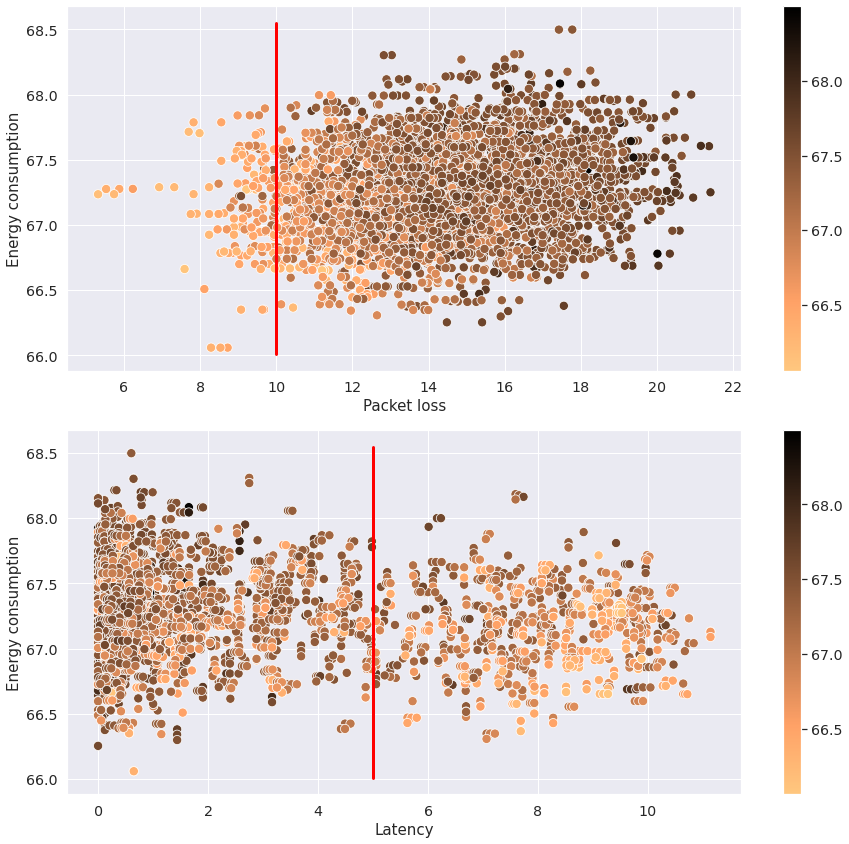

In [ ]:
cycle = 65
sub_df = df[df.cycle == nb_learnig_cycles + cycle]
visualize_optimization(sub_df)

#### Select the best adaptation option in the reduced adaptation space




In [ ]:
best_opt_reduced = []
reduced_verification_times = []
total_verification_times = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    total_verification_times.append(np.sum(sub_df['verification_time']))
    sub_df = sub_df[sub_df.thresholds_pred == True] # The reduced adaptation space by using prediction
    cycle_idx = list(np.argsort(sub_df['energyconsumption_pred']))
    best_opt = None
    count = 0
    while best_opt is None and count < len(cycle_idx):
        idx = cycle_idx[count]
        if all(sub_df.iloc[[idx]]['packetloss'] < 10) and all(sub_df.iloc[[idx]]['latency'] < 5):
            best_opt = sub_df.iloc[idx]
        reduced_verification_times.append(sub_df.iloc[idx]['verification_time'])
        count +=1
    best_opt_reduced.append(best_opt)

In [ ]:
print(len(reduced_verification_times))
print(np.sum(reduced_verification_times))
reduced_time = np.sum(reduced_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000
print(reduced_time, 'seconds')
print((np.sum(total_verification_times) - np.sum(reduced_verification_times)) / (nb_tot_cycles - (nb_learnig_cycles + 2)) * 0.05 / 1000 + reduced_time, 'seconds')

273
42054
0.15404395604395607 seconds
50.32281941391942 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 0


,EC_reduced,PL_reduced,LA_reduced
3366,66.7172,7.211480,0.244444
3366,67.3268,5.706035,1.007540
3366,67.6822,4.243675,0.753465
3366,67.8901,5.638625,0.494438
3366,67.2302,5.499205,0.251662


#### Select the best adaptation option in the complete adaptation space

In [ ]:
best_opts = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_goal == True] # The reduced adaptation space by using verification
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.energyconsumption == min(sub_df.energyconsumption)].iloc[0]
    best_opts.append(best_opt)

In [ ]:
total_verification_times = df[(df.cycle >= nb_learnig_cycles + 2) & (df.cycle < nb_tot_cycles)]['verification_time']
print(len(total_verification_times))
print(np.sum(total_verification_times))
print(np.sum(total_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000, 'seconds')

1118208
273963568
1003.5295531135531 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opts])
print('Nb of Nones:', nb_nones)
best_opts = [el for el in best_opts if el is not None ]
df_best_opts = pd.DataFrame(best_opts, columns=df.columns)
df_best_opts = df_best_opts[['energyconsumption', 'packetloss', 'latency']]
df_best_opts = df_best_opts.rename(columns={'energyconsumption' : 'EC_complete', 'packetloss' : 'PL_complete', 'latency': 'LA_complete'})
df_best_opts.head()

Nb of Nones: 0


,EC_complete,PL_complete,LA_complete
3231,66.2786,8.654530,1.91347
3924,66.4913,9.098275,1.33123
747,66.2231,6.542120,4.47989
3481,66.3425,8.936005,2.66038
3609,66.4678,7.883580,0.46467


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts])
combined_df.head()

,EC_reduced,PL_reduced,LA_reduced,EC_complete,PL_complete,LA_complete
3366,66.7172,7.211480,0.244444,NaN,NaN,NaN
3366,67.3268,5.706035,1.007540,NaN,NaN,NaN
3366,67.6822,4.243675,0.753465,NaN,NaN,NaN
3366,67.8901,5.638625,0.494438,NaN,NaN,NaN
3366,67.2302,5.499205,0.251662,NaN,NaN,NaN


#### Compare quality

In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))

66.34178424908423
67.14450622710622


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=53.0, pvalue=8.887212025218726e-46)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=7615.5, pvalue=1.118833691808518e-15)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=0.0, pvalue=4.9272225623697994e-46)


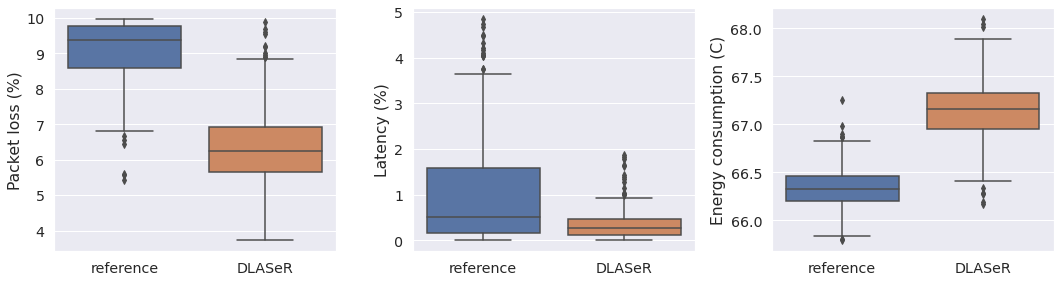

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(15,4.2))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'PL_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'DLASeR' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference', 'LA_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'DLASeR' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'EC_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'DLASeR' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.tight_layout()

#### 2 THRESHOLD GOALS -> Compare quality with DLASeR and Quin F. et al.

**SELECT BEST ADAPT OPTION IN REDUCED SPACE BY USING 2 THRESHOLD GOALS**

In [ ]:
best_opt_reduced = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_pred == True] # The reduced adaptation space by using prediction
    sub_df = sub_df[sub_df.thresholds_goal == True] # Since all of the reduced options will be verified
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.energyconsumption == min(sub_df.energyconsumption)].iloc[0]
    best_opt_reduced.append(best_opt)

In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 0


,EC_reduced,PL_reduced,LA_reduced
3519,66.6198,6.953955,0.57587
3924,66.4913,9.098275,1.33123
747,66.2231,6.542120,4.47989
3481,66.3425,8.936005,2.66038
3609,66.4678,7.883580,0.46467


**LOAD DATA QUIN F. et al**

In [ ]:
# Data from Quin F. et al
import pandas as pd
quin_df = pd.read_csv('data_overall_results_v2.tsv', delimiter='\t')
print(len(quin_df))
quin_df.head()

300


,Optimal_PL,Optimal_LA,Optimal_EC,Optimal_T,Classification_PL,Classification_LA,Classification_EC,Classification_T,Regression_PL,Regression_LA,Regression_EC,Regression_T
0,5.843910,2.064320,66.3575,677.326,5.843910,2.064320,66.3575,569.990342,5.843910,2.064320,66.3575,570.001258
1,8.983995,0.320988,66.4456,688.608,8.983995,0.320988,66.4456,569.945387,8.983995,0.320988,66.4456,569.956067
2,9.810195,1.538440,66.5019,745.565,9.810195,1.538440,66.5019,570.011300,9.810195,1.538440,66.5019,570.022317
3,8.936005,0.000000,66.6183,748.482,8.936005,0.000000,66.6183,569.958492,8.936005,0.000000,66.6183,569.970081
4,7.802200,0.000000,65.9961,741.365,7.802200,0.000000,65.9961,569.891541,7.802200,0.000000,65.9961,569.903733


**LOAD DATA DLASER**

In [ ]:
dlaser_df = pd.read_csv('DLASeR_T1-T2_v2.csv')
dlaser_df = dlaser_df.rename(columns={col : 'dlaser_' + col for col in dlaser_df.columns })
dlaser_df.head()

,dlaser_Unnamed: 0,dlaser_EC_reduced,dlaser_PL_reduced,dlaser_LA_reduced,dlaser_EC_complete,dlaser_PL_complete,dlaser_LA_complete
0,3231,66.2786,8.654530,1.91347,NaN,NaN,NaN
1,3924,66.4913,9.098275,1.33123,NaN,NaN,NaN
2,747,66.2231,6.542120,4.47989,NaN,NaN,NaN
3,3481,66.3425,8.936005,2.66038,NaN,NaN,NaN
4,3609,66.4678,7.883580,0.46467,NaN,NaN,NaN


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts, quin_df[['Classification_PL','Classification_LA','Classification_EC']], dlaser_df[['dlaser_PL_reduced', 'dlaser_LA_reduced', 'dlaser_EC_reduced']]])
combined_df.head()

,EC_reduced,PL_reduced,LA_reduced,EC_complete,PL_complete,LA_complete,Classification_PL,Classification_LA,Classification_EC,dlaser_PL_reduced,dlaser_LA_reduced,dlaser_EC_reduced
3519,66.6198,6.953955,0.57587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3924,66.4913,9.098275,1.33123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
747,66.2231,6.542120,4.47989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3481,66.3425,8.936005,2.66038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3609,66.4678,7.883580,0.46467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))
print(np.mean(dlaser_df['dlaser_EC_reduced']))
print(np.mean(quin_df['Optimal_EC']))
print(np.mean(combined_df['Classification_EC']))

66.34178424908423
66.41055750915751
66.38764212454213
66.35260933333338
66.39135933333337


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=275.0, pvalue=3.9786913816277255e-14)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=1587.0, pvalue=0.16636109262783494)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=0.0, pvalue=1.1918427542878216e-16)


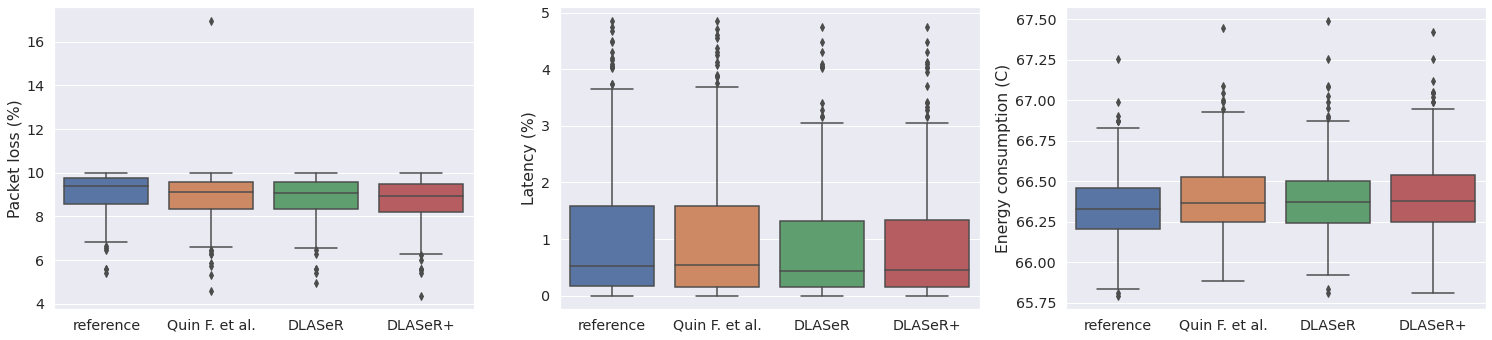

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(21,5))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'Classification_PL' : 'Quin F. et al.', 'dlaser_PL_reduced' : 'DLASeR', 'PL_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'Quin F. et al.', 'DLASeR', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'Quin F. et al.' : 'Classification_PL' , 'DLASeR' : 'dlaser_PL_reduced' ,'DLASeR+' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference', 'Classification_LA' : 'Quin F. et al.',  'dlaser_LA_reduced' : 'DLASeR', 'LA_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'Quin F. et al.', 'DLASeR', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'Quin F. et al.' : 'Classification_LA', 'DLASeR' : 'dlaser_LA_reduced', 'DLASeR+' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'Classification_EC' : 'Quin F. et al.', 'dlaser_EC_reduced' : 'DLASeR', 'EC_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'Quin F. et al.', 'DLASeR', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'Quin F. et al.' : 'Classification_EC', 'DLASeR' : 'dlaser_EC_reduced', 'DLASeR+' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.tight_layout()

#### 2 THRESHOLD GOALS & 1 OPTIMIZATION GOAL -> Compare quality with DLASeR and Quin F. et al.

**SELECT BEST ADAPT OPTION IN REDUCED SPACE BY USING 2 THRESHOLD GOALS AND 1 OPTIMIZATION GOAL**

In [ ]:
best_opt_reduced = []
reduced_verification_times = []
total_verification_times = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    total_verification_times.append(np.sum(sub_df['verification_time']))
    sub_df = sub_df[sub_df.thresholds_pred == True] # The reduced adaptation space by using prediction
    cycle_idx = list(np.argsort(sub_df['energyconsumption_pred']))
    best_opt = None
    count = 0
    while best_opt is None and count < len(cycle_idx):
        idx = cycle_idx[count]
        if all(sub_df.iloc[[idx]]['packetloss'] < 10) and all(sub_df.iloc[[idx]]['latency'] < 5):
            best_opt = sub_df.iloc[idx]
        reduced_verification_times.append(sub_df.iloc[idx]['verification_time'])
        count +=1
    best_opt_reduced.append(best_opt)

In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 0


,EC_reduced,PL_reduced,LA_reduced
3366,66.7172,7.211480,0.244444
3366,67.3268,5.706035,1.007540
3366,67.6822,4.243675,0.753465
3366,67.8901,5.638625,0.494438
3366,67.2302,5.499205,0.251662


**LOAD DATA DLASER**

In [ ]:
dlaser_df = pd.read_csv('DLASeR_TTO_v2.csv')
dlaser_df = dlaser_df.rename(columns={col : 'dlaser_' + col for col in dlaser_df.columns })
dlaser_df.head()

,dlaser_Unnamed: 0,dlaser_EC_reduced,dlaser_PL_reduced,dlaser_LA_reduced,dlaser_EC_complete,dlaser_PL_complete,dlaser_LA_complete
0,672,66.7699,8.887595,1.889530,NaN,NaN,NaN
1,3123,67.4004,8.654530,2.401360,NaN,NaN,NaN
2,3123,66.5829,7.211480,0.391841,NaN,NaN,NaN
3,3123,67.2064,8.722520,1.496120,NaN,NaN,NaN
4,3285,67.0502,6.358585,2.157540,NaN,NaN,NaN


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts, dlaser_df[['dlaser_PL_reduced', 'dlaser_LA_reduced', 'dlaser_EC_reduced']]])
combined_df.head()

,EC_reduced,PL_reduced,LA_reduced,EC_complete,PL_complete,LA_complete,dlaser_PL_reduced,dlaser_LA_reduced,dlaser_EC_reduced
3366,66.7172,7.211480,0.244444,NaN,NaN,NaN,NaN,NaN,NaN
3366,67.3268,5.706035,1.007540,NaN,NaN,NaN,NaN,NaN,NaN
3366,67.6822,4.243675,0.753465,NaN,NaN,NaN,NaN,NaN,NaN
3366,67.8901,5.638625,0.494438,NaN,NaN,NaN,NaN,NaN,NaN
3366,67.2302,5.499205,0.251662,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))
print(np.mean(dlaser_df['dlaser_EC_reduced']))

66.34178424908423
67.14450622710622
67.07615421245421


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=53.0, pvalue=8.887212025218726e-46)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=7615.5, pvalue=1.118833691808518e-15)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=0.0, pvalue=4.9272225623697994e-46)


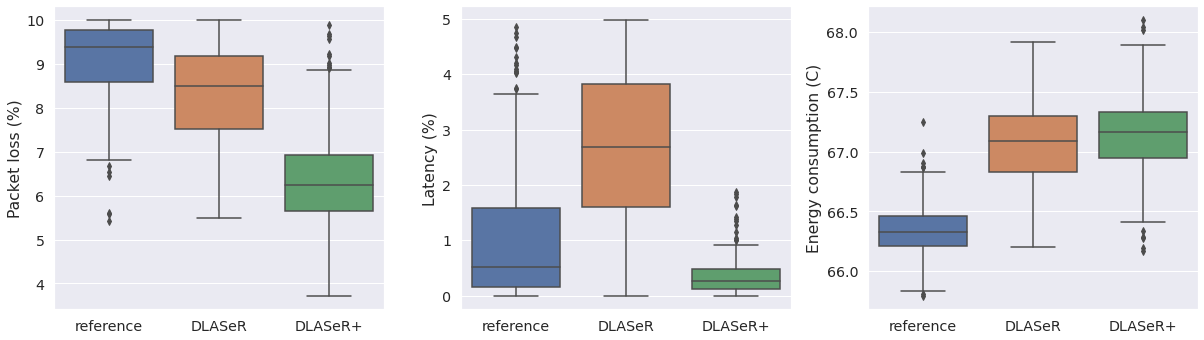

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(17,5))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'dlaser_PL_reduced' : 'DLASeR', 'PL_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'DLASeR', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'DLASeR' : 'dlaser_PL_reduced' ,'DLASeR+' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference',  'dlaser_LA_reduced' : 'DLASeR', 'LA_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'DLASeR', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'DLASeR' : 'dlaser_LA_reduced', 'DLASeR+' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'dlaser_EC_reduced' : 'DLASeR', 'EC_reduced' : 'DLASeR+'})
sns.boxplot(data=combined_df[['reference', 'DLASeR', 'DLASeR+']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'DLASeR' : 'dlaser_EC_reduced', 'DLASeR+' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.tight_layout()

## Setup 2

In [ ]:
thresh = 0.5

In [ ]:
df_setup2 = pd.read_csv('df_setup2_online_with_exploration_v2.csv')
df_setup2.head()

,Unnamed: 0,cycle,pred_latency_thresh5,pred_packetloss_thresh10,pred_energyconsumption_setpoint67,actual_pl,actual_la,actual_ec
0,0,1,0.000026,0.000020,0.368695,14.93810,10.136800,67.1711
1,1,1,0.001975,0.000046,0.320219,15.66495,8.113950,67.2211
2,2,1,0.647782,0.000233,0.269653,16.46750,5.346690,67.2314
3,3,1,0.999560,0.001000,0.250121,16.70270,0.270563,67.4282
4,4,1,0.005899,0.000061,0.312525,14.30010,4.370580,67.4370


### DNN model

**T1**: PL < 10%  
**T2**: LA < 5%  
**S1**: EC == 67 +/- 0.3

In [12]:
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
# Optimal params
params = {
    'core_layers': [200,100,50,25],
    'class_layers': [40,20,10,5],
    'scaler': StandardScaler(),
    'epochs': 30,
    'optimizer': Adam,
    'lr': 2e-3,
    'batch_size': 512
    }

In [13]:
dlaser = DLASeR(['packetloss', 'latency', 'energyconsumption'], params['core_layers'])
dlaser.add_theshold_goal('packetloss', Operator.Min, 10, params['class_layers'])
dlaser.add_theshold_goal('latency', Operator.Min, 5, params['class_layers'])
dlaser.add_setpoint_goal('energyconsumption', 67, 0.3, params['class_layers'])
dlaser.compile(optimizer=params['optimizer'], lr=params['lr'])
dlaser.print_goals()
print('\n')
dlaser.print_model()

---------- THRESHOLD GOALS ----------
packetloss < 10
latency < 5
---------- SET-POINT GOALS ----------
energyconsumption == 67


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 207)          0                                            
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 200)          41600       main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 200)          800         dense_31[0][0]                   
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 100)          20100  

### Total reduction of all three goals

In [ ]:
import random

nb_verifications = []
start_cycle = LEARNING_CYCLES + 1
nones = 0
setup_df = df_setup2
for c in range(start_cycle, max(setup_df.cycle)):
    cycle_df = setup_df[setup_df.cycle == c]

    cycle_idx = [i for i in range(nb_opts)]
    random.shuffle(cycle_idx)
    count = 0
    nb_count = 0
    valid = False
    while not valid and count < nb_opts:
        idx = cycle_idx[count]
        if all(cycle_df.iloc[[idx]]['pred_packetloss_thresh10'] > thresh) and all(cycle_df.iloc[[idx]]['pred_latency_thresh5'] > thresh) and all(cycle_df.iloc[[idx]]['pred_energyconsumption_setpoint67'] > thresh):
            if all(cycle_df.iloc[[idx]]['actual_pl'] < 10) and all(cycle_df.iloc[[idx]]['actual_la'] < 5) and all(cycle_df.iloc[[idx]]['actual_ec'] < 67.3) and all(cycle_df.iloc[[idx]]['actual_ec'] > 66.7) :
                valid = True
            nb_count += 1
        count +=1
    if not valid:
        nones += 1
    #else:
    nb_verifications.append(nb_count)

AASR

In [ ]:
print('AASR:')
reduction = np.sum((df_setup2['pred_packetloss_thresh10']>thresh)&(df_setup2['pred_latency_thresh5']>thresh)&(df_setup2['pred_energyconsumption_setpoint67']>thresh)) / len(df_setup2)
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

AASR:
0.9576572516025641
Amount that we retain:
0.042342748397435896


AANR

In [ ]:
print('AANR:')
reduction = np.sum(nb_verifications)/np.sum((df_setup2['pred_packetloss_thresh10']>thresh)&(df_setup2['pred_latency_thresh5']>thresh)&(df_setup2['pred_energyconsumption_setpoint67']>thresh))
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

AANR:
0.9852792092591028
Amount that we retain:
0.014720790740897187


Total reduction

In [ ]:
print('Total reduction:')
reduction = np.sum(nb_verifications)/len(df_setup2)# - nones_verified)
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

Total reduction:
0.9993766812614469
Amount that we retain:
0.0006233187385531135


In [ ]:
print('Nb nones:', nones)

Nb nones: 23


### Quality of total reduction

In [ ]:
setup_df = df_setup2

df['packetloss_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'packetloss_pred'] = setup_df['pred_packetloss_thresh10'] > thresh
df['latency_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'latency_pred'] = setup_df['pred_latency_thresh5'] > thresh
df['energyconsumption_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'energyconsumption_pred'] = setup_df['pred_energyconsumption_setpoint67']

df['thresholds_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_pred'] = np.array((setup_df['pred_packetloss_thresh10'] > thresh) & (setup_df['pred_latency_thresh5'] > thresh)).astype(bool)
df['thresholds_goal'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_goal'] = np.array((setup_df['actual_pl'] < 10) & (setup_df['actual_la'] < 5)).astype(bool)
df.head()

,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,link17_distribution,link18_distribution,link19_distribution,link20_distribution,link21_distribution,link22_distribution,link23_distribution,link24_distribution,link25_distribution,link26_distribution,link27_distribution,link28_distribution,link29_distribution,link30_distribution,link31_distribution,link32_distribution,link33_distribution,link34_distribution,link35_distribution,link36_distribution,...,env_link7_power,env_link8_power,env_link9_power,env_link10_power,env_link11_power,env_link12_power,env_link13_power,env_link14_power,env_link15_power,env_link16_power,env_link17_power,env_link18_power,env_link19_power,env_link20_power,env_link21_power,env_link22_power,env_link23_power,env_link24_power,env_link25_power,env_link26_power,env_link27_power,env_link28_power,env_link29_power,env_link30_power,env_link31_power,env_link32_power,env_link33_power,env_link34_power,env_link35_power,env_link36_power,env_link37_power,env_link38_power,env_link39_power,env_link40_power,env_link41_power,packetloss_pred,latency_pred,energyconsumption_pred,thresholds_pred,thresholds_goal
0,67.0489,13.80960,9.339190,100,0,100,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0
1,67.3800,14.51095,5.043880,100,34,66,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0
2,67.3874,15.23420,1.534230,100,68,32,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0
3,67.3815,16.39665,0.128205,100,100,0,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0
4,67.3922,13.10035,3.992940,100,0,100,100,100,34,66,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0,0,0.0,0,0


#### Visualize the prediction

[]

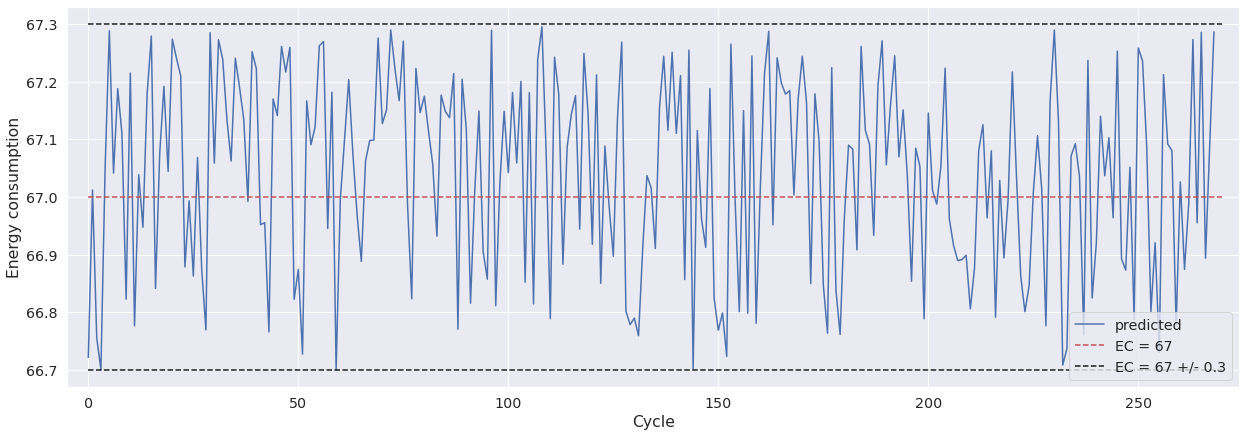

In [ ]:
setup_df = df_setup2

import seaborn as sns
sns.set(font_scale=1.3)

plt.figure(figsize=(21,7))
plt.plot(df_best_opt_reduced['EC_reduced'].values, label='predicted')
plt.plot([0,270],[67, 67], 'r--', label='EC = 67')
plt.plot([0,270],[67.3, 67.3], 'k--', label='EC = 67 +/- 0.3')
plt.plot([0,270],[66.7, 66.7], 'k--')
plt.ylabel('Energy consumption')
plt.xlabel('Cycle')
plt.legend()
plt.xlim(-5,274)
plt.plot()

**TODO**

#### Select the best adaptation option in the reduced adaptation space




In [ ]:
best_opt_reduced = []
reduced_verification_times = []
total_verification_times = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    total_verification_times.append(np.sum(sub_df['verification_time']))
    sub_df = sub_df[sub_df.thresholds_pred == True] # The reduced adaptation space by using prediction

    #reduction_size = np.sum(cycle_df['pred_energyconsumption_setpoint12.9']>thresh)

    cycle_idx = [i for i in range(len(sub_df))]
    random.shuffle(cycle_idx)
    best_opt = None
    count = 0
    while best_opt is None and count < len(cycle_idx):
        idx = cycle_idx[count]
        if all(sub_df.iloc[[idx]]['packetloss'] < 10) and all(sub_df.iloc[[idx]]['latency'] < 5) and all(sub_df.iloc[[idx]]['energyconsumption'] < 67.3) and all(sub_df.iloc[[idx]]['energyconsumption'] > 66.7):
            best_opt = sub_df.iloc[idx]
        reduced_verification_times.append(sub_df.iloc[idx]['verification_time'])
        count +=1
    best_opt_reduced.append(best_opt)

In [ ]:
print(len(reduced_verification_times))
print(np.sum(reduced_verification_times))
reduced_time = np.sum(reduced_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000
print(reduced_time, 'seconds')
print((np.sum(total_verification_times) - np.sum(reduced_verification_times)) / (nb_tot_cycles - (nb_learnig_cycles + 2)) * 0.05 / 1000 + reduced_time, 'seconds')

781
149950
0.5492673992673992 seconds
50.69828168498169 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 4


,EC_reduced,PL_reduced,LA_reduced
3513,66.7219,9.525095,1.588950
3571,67.0121,8.212225,0.259870
3496,66.7558,9.259510,1.549860
3339,66.7006,6.263205,0.512829
3285,67.0502,6.358585,2.157540


#### Select the best adaptation option in the complete adaptation space

In [ ]:
best_opts = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_goal == True] # The reduced adaptation space by using verification
    best_opt = None
    count = 0
    cycle_idx = [i for i in range(len(sub_df))]
    random.shuffle(cycle_idx)
    valid = False
    while not valid and count < len(sub_df):
        idx = cycle_idx[count]
        if (sub_df.iloc[idx]['energyconsumption'] < 67.3 and sub_df.iloc[idx]['energyconsumption'] > 66.7):
            valid = True
            best_opt = sub_df.iloc[idx]#[abs(sub_df.energyconsumption - 67) == min(abs(sub_df.energyconsumption - 67))].iloc[0]
        count += 1
    best_opts.append(best_opt)

In [ ]:
total_verification_times = df[(df.cycle >= nb_learnig_cycles + 2) & (df.cycle < nb_tot_cycles)]['verification_time']
print(len(total_verification_times))
print(np.sum(total_verification_times))
print(np.sum(total_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000, 'seconds')

1118208
273963568
1003.5295531135531 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opts])
print('Nb of Nones:', nb_nones)
best_opts = [el for el in best_opts if el is not None ]
df_best_opts = pd.DataFrame(best_opts, columns=df.columns)
df_best_opts = df_best_opts[['energyconsumption', 'packetloss', 'latency']]
df_best_opts = df_best_opts.rename(columns={'energyconsumption' : 'EC_complete', 'packetloss' : 'PL_complete', 'latency': 'LA_complete'})
df_best_opts.head()

Nb of Nones: 0


,EC_complete,PL_complete,LA_complete
758,67.0813,9.525095,0.000000
755,67.0384,9.723685,0.000000
762,67.2499,7.857885,0.751765
3843,67.2251,7.432835,0.509259
351,67.1128,9.744465,1.235470


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts])
combined_df.head()

,EC_reduced,PL_reduced,LA_reduced,EC_complete,PL_complete,LA_complete
3357,66.9210,5.602510,0.365961,NaN,NaN,NaN
876,66.9557,8.603460,4.322010,NaN,NaN,NaN
2077,67.0794,9.572020,3.286190,NaN,NaN,NaN
2205,66.7950,8.063205,0.633698,NaN,NaN,NaN
3347,67.0413,7.457315,0.000000,NaN,NaN,NaN


#### Compare quality

In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))

67.0257981684982
67.02585130111525


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=15303.0, pvalue=0.07820928295657273)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=16614.0, pvalue=0.48053947538394814)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=17599.5, pvalue=0.9011459046341976)


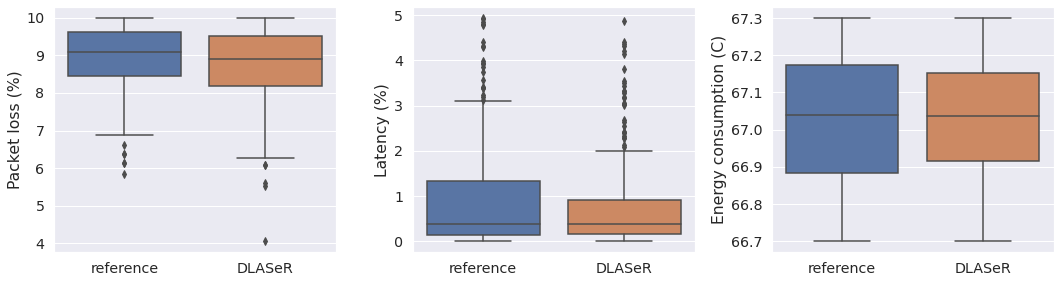

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(15,4.2))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'PL_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'DLASeR' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference', 'LA_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'DLASeR' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'EC_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'DLASeR' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.tight_layout()

## Setup 3

In [ ]:
thresh = 0.5

In [ ]:
df_setup3 = pd.read_csv('df_setup3_online_with_exploration_v2.csv')
df_setup3.head()

,Unnamed: 0,cycle,pred_packetloss_opt,pred_latency_thresh5,pred_energyconsumption_setpoint67,actual_pl,actual_la,actual_ec
0,0,1,12.134608,0.000004,0.714599,14.93810,10.136800,67.1711
1,1,1,12.986319,0.001314,0.681136,15.66495,8.113950,67.2211
2,2,1,13.826307,0.653029,0.606438,16.46750,5.346690,67.2314
3,3,1,14.545271,0.998059,0.590381,16.70270,0.270563,67.4282
4,4,1,11.990010,0.000601,0.663997,14.30010,4.370580,67.4370


### DNN model

**T1**: PL < 10%  
**T2**: LA < 5%  
**S1**: EC == 67 +/- 0.3

In [12]:
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
# Optimal params
params = {
    'core_layers': [200,100,50,25],
    'class_layers': [40,20,10,5],
    'scaler': StandardScaler(),
    'epochs': 30,
    'optimizer': Adam,
    'lr': 2e-3,
    'batch_size': 512
    }

In [13]:
dlaser = DLASeR(['packetloss', 'latency', 'energyconsumption'], params['core_layers'])
dlaser.add_theshold_goal('packetloss', Operator.Min, 10, params['class_layers'])
dlaser.add_theshold_goal('latency', Operator.Min, 5, params['class_layers'])
dlaser.add_setpoint_goal('energyconsumption', 67, 0.3, params['class_layers'])
dlaser.compile(optimizer=params['optimizer'], lr=params['lr'])
dlaser.print_goals()
print('\n')
dlaser.print_model()

---------- THRESHOLD GOALS ----------
packetloss < 10
latency < 5
---------- SET-POINT GOALS ----------
energyconsumption == 67


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 207)          0                                            
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 200)          41600       main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 200)          800         dense_31[0][0]                   
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 100)          20100  

### Total reduction of all three goals

In [ ]:
nb_verifications = []
start_cycle = LEARNING_CYCLES + 1
nones = 0
nones_verified = 0
setup_df = df_setup3
for c in range(start_cycle, max(setup_df.cycle)):
    cycle_df = setup_df[setup_df.cycle == c]
    cycle_df = cycle_df[(cycle_df.pred_latency_thresh5 > thresh) & (cycle_df['pred_energyconsumption_setpoint67'] > thresh)] # Threshold and setpoint reduction
    cycle_idx = list(np.argsort(cycle_df['pred_packetloss_opt']))
    count = 0
    nb_count = 0
    valid = False
    while not valid and count < len(cycle_idx):
        idx = cycle_idx[count]
        #if all(cycle_df.iloc[[idx]]['pred_latency_thresh5'] > thresh) and all(cycle_df.iloc[[idx]]['pred_energyconsumption_setpoint12.9'] > thresh):
        if all(cycle_df.iloc[[idx]]['actual_la'] < 5) and all(cycle_df.iloc[[idx]]['actual_ec'] < 67.3) and all(cycle_df.iloc[[idx]]['actual_ec'] > 66.7):
            valid = True
        count +=1
    if not valid:
        nones += 1
        nones_verified += count
    nb_verifications.append(count)

AASR

In [ ]:
print('AASR:')
reduction = np.sum((df_setup3['pred_latency_thresh5']>thresh)&(df_setup3['pred_energyconsumption_setpoint67']>thresh))/len(df_setup3)
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

AASR:
0.5860153030563187
Amount that we retain:
0.41398469694368134


AANR

In [ ]:
print('AANR:')
reduction = np.sum(nb_verifications)/np.sum((df_setup3['pred_latency_thresh5']>thresh)&(df_setup3['pred_energyconsumption_setpoint67']>thresh))
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

AANR:
0.9986866009535105
Amount that we retain:
0.0013133990464895737


Total reduction

In [ ]:
print('Total reduction:')
reduction = np.sum(nb_verifications)/len(df_setup3)# - nones_verified)
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

Total reduction:
0.9994562728937729
Amount that we retain:
0.0005437271062271062


In [ ]:
print('Nb nones:', nones)

Nb nones: 5


### Quality of total reduction

In [ ]:
setup_df = df_setup3

df['packetloss_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'packetloss_pred'] = setup_df['pred_packetloss_opt']
df['latency_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'latency_pred'] = setup_df['pred_latency_thresh5'] > thresh
df['energyconsumption_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'energyconsumption_pred'] = setup_df['pred_energyconsumption_setpoint67']

df['thresholds_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_pred'] = np.array(setup_df['pred_latency_thresh5'] > thresh).astype(bool)
df['thresholds_goal'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_goal'] = np.array(setup_df['actual_la'] < 5).astype(bool)

df['setpoints_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'setpoints_pred'] = np.array(setup_df['pred_energyconsumption_setpoint67'] > thresh).astype(bool)
df['setpoints_goal'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'setpoints_goal'] = np.array((setup_df['actual_ec'] < 67.3) & (setup_df['actual_ec'] > 66.7)).astype(bool)

df.head()

,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,link17_distribution,link18_distribution,link19_distribution,link20_distribution,link21_distribution,link22_distribution,link23_distribution,link24_distribution,link25_distribution,link26_distribution,link27_distribution,link28_distribution,link29_distribution,link30_distribution,link31_distribution,link32_distribution,link33_distribution,link34_distribution,link35_distribution,link36_distribution,...,env_link9_power,env_link10_power,env_link11_power,env_link12_power,env_link13_power,env_link14_power,env_link15_power,env_link16_power,env_link17_power,env_link18_power,env_link19_power,env_link20_power,env_link21_power,env_link22_power,env_link23_power,env_link24_power,env_link25_power,env_link26_power,env_link27_power,env_link28_power,env_link29_power,env_link30_power,env_link31_power,env_link32_power,env_link33_power,env_link34_power,env_link35_power,env_link36_power,env_link37_power,env_link38_power,env_link39_power,env_link40_power,env_link41_power,packetloss_pred,latency_pred,energyconsumption_pred,thresholds_pred,thresholds_goal,setpoints_pred,setpoints_goal
0,67.0489,13.80960,9.339190,100,0,100,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0,0.0,0,0,0,0
1,67.3800,14.51095,5.043880,100,34,66,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0,0.0,0,0,0,0
2,67.3874,15.23420,1.534230,100,68,32,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0,0.0,0,0,0,0
3,67.3815,16.39665,0.128205,100,100,0,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0,0.0,0,0,0,0
4,67.3922,13.10035,3.992940,100,0,100,100,100,34,66,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0,0.0,0,0,0,0


#### Visualize the prediction

In [ ]:
import seaborn as sns
def visualize_optimization(sub_df):
    sns.set(font_scale=1.3)  # crazy big
    plt.subplots(2,1, figsize=(13,12))

    pal = 'copper_r'

    plt.subplot(2,1,1)
    g = sns.scatterplot(x='latency', y='packetloss', data=sub_df, hue='packetloss_pred', s=85, legend=False, palette=pal)
    plt.plot([5, 5],[min(sub_df['packetloss']) - 0.45, max(sub_df['packetloss']) + 0.45], color='red', linewidth=3)
    plt.xlabel('Latency', fontsize=15)
    plt.ylabel('Packet loss', fontsize=15)
    norm = plt.Normalize(min(sub_df['packetloss']), max(sub_df['packetloss']))
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    g.figure.colorbar(sm)

    plt.subplot(2,1,2)
    g = sns.scatterplot(x='energyconsumption', y='packetloss', data=sub_df, hue='packetloss_pred', s=85, legend=False, palette=pal)
    plt.plot([66.7, 66.7],[min(sub_df['packetloss']) - 0.45, max(sub_df['packetloss']) + 0.45], color='red', linewidth=3)
    plt.plot([67, 67],[min(sub_df['packetloss']) - 0.45, max(sub_df['packetloss']) + 0.45], color='green', linewidth=3)
    plt.plot([67.3, 67.3],[min(sub_df['packetloss']) - 0.45, max(sub_df['packetloss']) + 0.45], color='red', linewidth=3)
    plt.xlabel('Energy consumption', fontsize=15)
    plt.ylabel('Packet loss', fontsize=15)
    norm = plt.Normalize(min(sub_df['packetloss']), max(sub_df['packetloss']))
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    g.figure.colorbar(sm)

    plt.tight_layout()

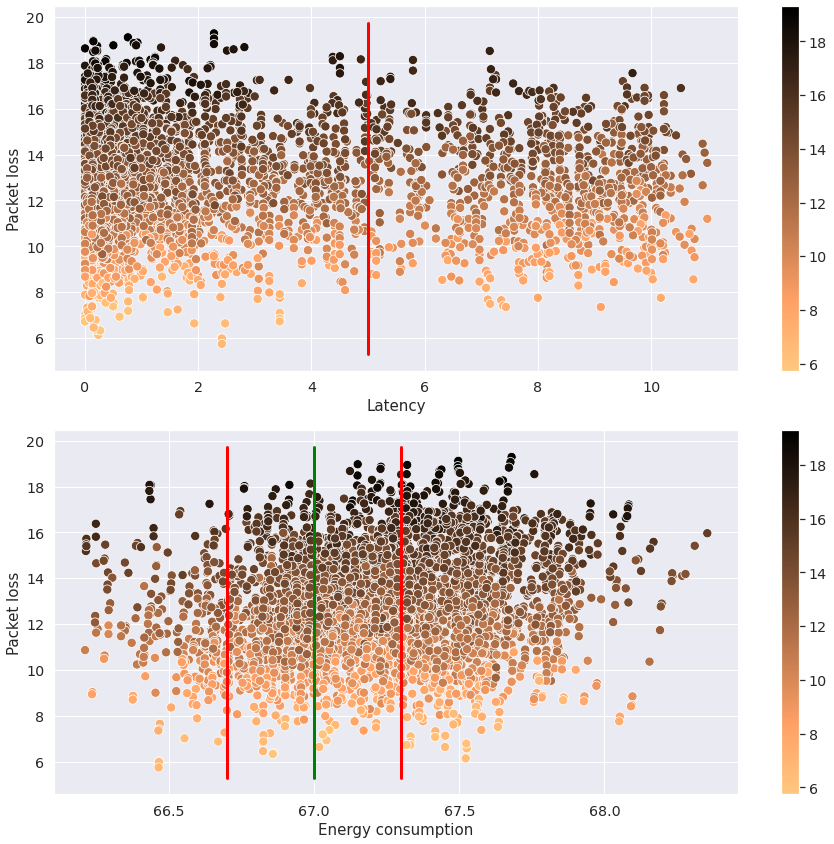

In [ ]:
cycle = 27 # 27
sub_df = df[df.cycle == nb_learnig_cycles + cycle]
visualize_optimization(sub_df)

#### Select the best adaptation option in the reduced adaptation space




In [ ]:
best_opt_reduced = []
reduced_verification_times = []
total_verification_times = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    total_verification_times.append(np.sum(sub_df['verification_time']))
    sub_df = sub_df[(sub_df.thresholds_pred == True) & (sub_df.setpoints_pred == True)] # The reduced adaptation space by using prediction

    cycle_idx = list(np.argsort(sub_df['packetloss_pred'])) # [::-1] to make it descending
    best_opt = None
    count = 0
    while best_opt is None and count < len(cycle_idx):
        idx = cycle_idx[count]
        if all(sub_df.iloc[[idx]]['latency'] < 5) and all(sub_df.iloc[[idx]]['energyconsumption'] <= 67.3) and all(sub_df.iloc[[idx]]['energyconsumption'] >= 66.7):
            best_opt = sub_df.iloc[idx]
        reduced_verification_times.append(sub_df.iloc[idx]['verification_time'])
        count +=1
    best_opt_reduced.append(best_opt)

In [ ]:
print(len(reduced_verification_times))
print(np.sum(reduced_verification_times))
reduced_time = np.sum(reduced_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000
print(reduced_time, 'seconds')
print((np.sum(total_verification_times) - np.sum(reduced_verification_times)) / (nb_tot_cycles - (nb_learnig_cycles + 2)) * 0.05 / 1000 + reduced_time, 'seconds')

644
103548
0.3792967032967033 seconds
50.536809523809524 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 5


,EC_reduced,PL_reduced,LA_reduced
3364,66.7328,7.909135,0.244444
3356,67.1277,5.706035,0.000000
3364,67.2000,5.809970,0.083004
3356,66.8310,6.419560,0.064516
3364,67.2356,5.976305,0.037037


#### Select the best adaptation option in the complete adaptation space

In [ ]:
best_opts = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[(sub_df.thresholds_goal == True) & (sub_df.setpoints_goal == True)] # The reduced adaptation space by using verification
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.packetloss == min(abs(sub_df.packetloss))].iloc[0]
    best_opts.append(best_opt)

In [ ]:
total_verification_times = df[(df.cycle >= nb_learnig_cycles + 2) & (df.cycle < nb_tot_cycles)]['verification_time']
print(len(total_verification_times))
print(np.sum(total_verification_times))
print(np.sum(total_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000, 'seconds')

1118208
273963568
1003.5295531135531 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opts])
print('Nb of Nones:', nb_nones)
best_opts = [el for el in best_opts if el is not None ]
df_best_opts = pd.DataFrame(best_opts, columns=df.columns)
df_best_opts = df_best_opts[['energyconsumption', 'packetloss', 'latency']]
df_best_opts = df_best_opts.rename(columns={'energyconsumption' : 'EC_complete', 'packetloss' : 'PL_complete', 'latency': 'LA_complete'})
df_best_opts.head()

Nb of Nones: 0


,EC_complete,PL_complete,LA_complete
3357,66.9210,5.602510,0.365961
3267,67.2995,5.173835,3.242040
3283,67.0971,4.543650,2.585090
3348,67.2064,5.285080,0.887530
3366,67.2302,5.499205,0.251662


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts])
combined_df.head()

,EC_reduced,PL_reduced,LA_reduced,EC_complete,PL_complete,LA_complete
3364,66.7328,7.909135,0.244444,NaN,NaN,NaN
3356,67.1277,5.706035,0.000000,NaN,NaN,NaN
3364,67.2000,5.809970,0.083004,NaN,NaN,NaN
3356,66.8310,6.419560,0.064516,NaN,NaN,NaN
3364,67.2356,5.976305,0.037037,NaN,NaN,NaN


#### Compare quality

In [ ]:
print(np.mean(combined_df['PL_complete']))
print(np.mean(combined_df['PL_reduced']))

6.342987179487174
7.271830149253728


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=5937.0, pvalue=2.9813765849778654e-21)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=14028.0, pvalue=0.025636542476841478)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=16471.0, pvalue=0.2615447971330923)


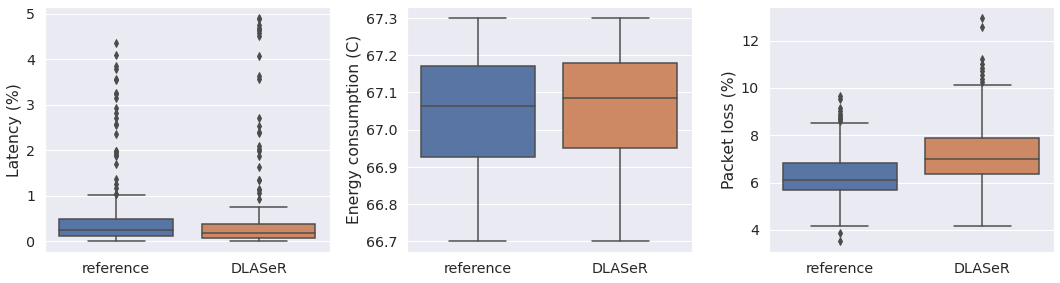

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(15,4.2))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference', 'LA_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'DLASeR' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'EC_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'DLASeR' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'PL_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'DLASeR' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.tight_layout()